# Installs & Imports

In [ ]:
!pip install -q einops
!pip install -q local-attention
!pip install -q matplotlib
!pip install -q plotly
!pip install -q kaleido
!pip install -q numpy
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q scipy
!pip install -q sktime
!pip install -q sympy
!pip install -q torch
!pip install -q tqdm
!pip install -q dask[dataframe]
!pip install -q triton
!pip install -q mamba-ssm
!pip install -q yfinance
!pip install -q optuna

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import plotly.io as pio
from IPython.display import display, Image, SVG
import plotly.express as px

from mamba_ssm import Mamba
import yfinance as yf
import optuna

In [ ]:
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Data Loading

In [ ]:
def load_data():
    """
    Load a time series dataset using yfinance. Fetch daily AAPL closing prices
    from 2010-01-01 to 2020-01-01. Ensure the dataframe has:
    - A DatetimeIndex
    - A single 'Value' column containing the closing prices

    Returns
    -------
    df : pd.DataFrame
        DataFrame with a DatetimeIndex and a 'Value' column.
    """
    df = yf.download('AAPL', start='2010-01-01', end='2020-01-01', progress=False)
    df = pd.DataFrame(df['Close'].values, index=df.index, columns=['Value'])
    return df

# Load the dataset
df = load_data()
display(df.head(30))
print(f"\nDataset length: {len(df)}")

,Value
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714
2010-01-11,7.503929
2010-01-12,7.418571
2010-01-13,7.523214
2010-01-14,7.479643



Dataset length: 2516


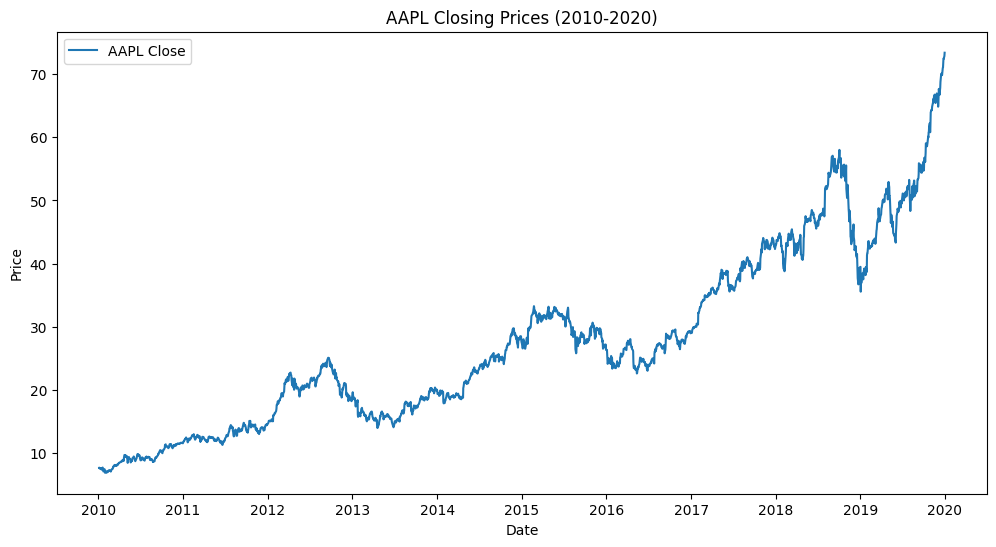

Dataset length: 2516 data points


In [ ]:
def visualize_data(df):
    """
    Plot the time series to visualize its behavior.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Value'], label='AAPL Close')
    plt.title('AAPL Closing Prices (2010-2020)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    print(f"Dataset length: {len(df)} data points")

# Visualize the time series
visualize_data(df)

# Data Exploration

In [ ]:
# Summary statistics
print("Summary Statistics:")
display(df.describe())

Summary Statistics:


,Value
count,2516.000000
mean,27.586323
std,14.043239
min,6.858929
25%,16.178571
50%,24.870000
75%,37.638125
max,73.412498


In [ ]:
def check_stationarity(timeseries, column_name='Value', cutoff=0.01):
    """
    Perform the Augmented Dickey-Fuller test to check for stationarity of a time series.

    Parameters
    ----------
    timeseries : pd.DataFrame or pd.Series
        The time series data. If a DataFrame is provided, 'column_name' must exist in it.
    column_name : str
        The name of the column containing the time series values if a DataFrame is given.
    cutoff : float
        p-value cutoff for determining stationarity. If p-value < cutoff, consider series stationary.

    Returns
    -------
    dfoutput : pd.Series
        Series containing ADF test results.
    stationary : bool
        True if the series is considered stationary, False otherwise.
    """
    if isinstance(timeseries, pd.DataFrame):
        if column_name not in timeseries.columns:
            raise ValueError(f"Column '{column_name}' not found in the dataframe.")
        series = timeseries[column_name]
    else:
        series = timeseries

    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series({
        'Test Statistic': dftest[0],
        'p-value': dftest[1],
        '# Lags Used': dftest[2],
        'Number of Observations Used': dftest[3],
        'Critical Value (1%)': dftest[4]['1%'],
        'Critical Value (5%)': dftest[4]['5%'],
        'Critical Value (10%)': dftest[4]['10%']
    }, name='ADF Test Results')

    stationary = dfoutput['p-value'] < cutoff
    return dfoutput, stationary

In [ ]:
# Run stationarity check
adf_results, is_stationary = check_stationarity(df, column_name='Value')
display(adf_results)
print("Is time series stationary?", is_stationary)

,ADF Test Results
Test Statistic,1.444835
p-value,0.997309
# Lags Used,9.000000
Number of Observations Used,2506.000000
Critical Value (1%),-3.432962
Critical Value (5%),-2.862694
Critical Value (10%),-2.567384


Is time series stationary? False


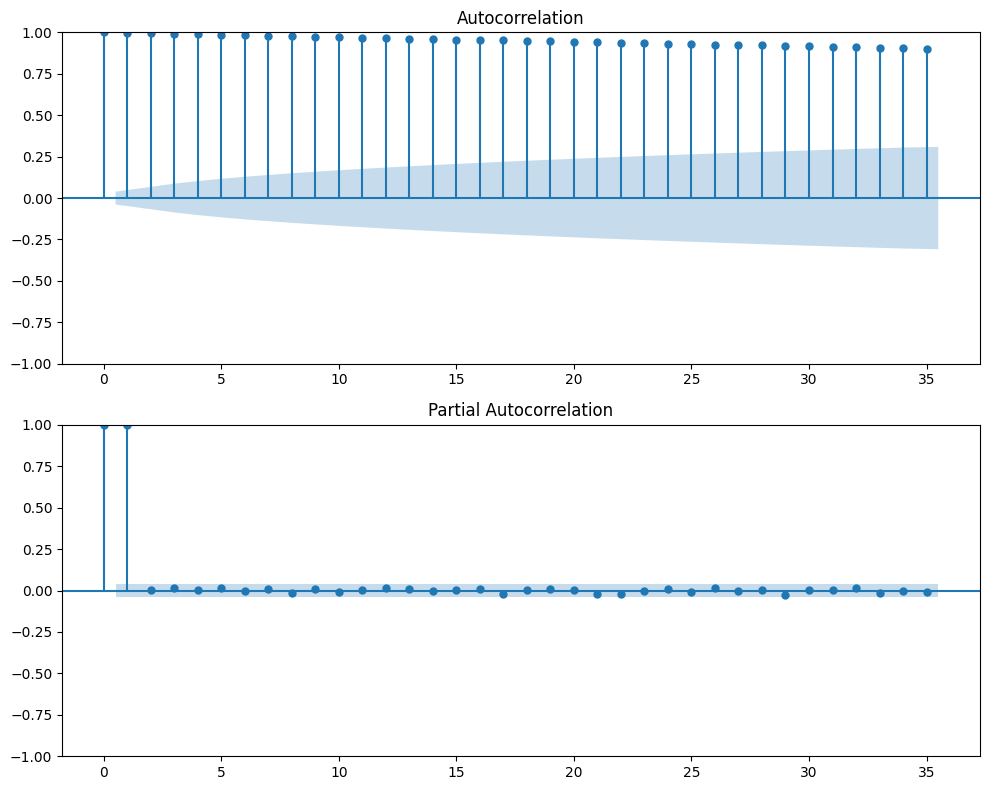

In [ ]:
# Plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['Value'], ax=ax[0])
ax[0].set_title('Autocorrelation')
print("\n")
plot_pacf(df['Value'], ax=ax[1])
ax[1].set_title('Partial Autocorrelation')
plt.tight_layout()
plt.show()

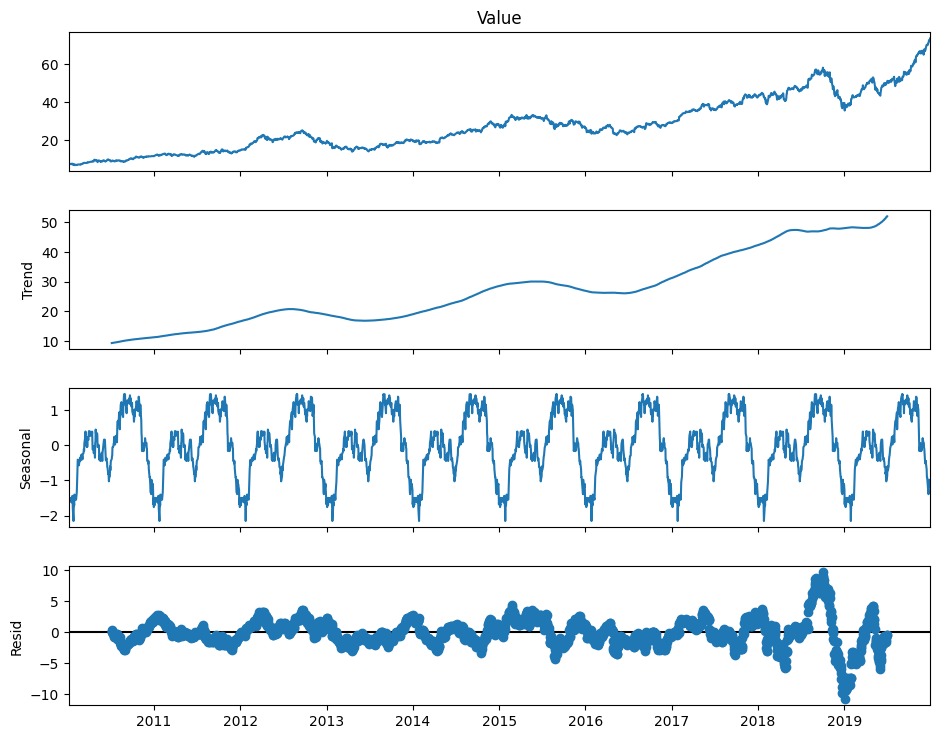

In [ ]:
# Decompose the series to check seasonality
try:
    decomposition = seasonal_decompose(df['Value'], model='additive', period=252)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.show()
except:
    print("Decomposition failed, possibly due to data frequency or chosen period.")

# Feature Engineering

In [ ]:
def create_time_features(index):
    """
    Create time features from a DatetimeIndex.
    For daily data, we'll consider: [month, day, weekday, dayofyear, quarter]

    Parameters
    ----------
    index : pd.DatetimeIndex
        Index of dates.

    Returns
    -------
    time_features : np.ndarray
        Time-based features array of shape [len(index), 5].
    """
    month = index.month.values
    day = index.day.values
    weekday = index.weekday.values
    day_of_year = index.dayofyear.values
    quarter = index.quarter.values

    time_features = np.stack([month, day, weekday, day_of_year, quarter], axis=1)
    return time_features

In [ ]:
# Create time-based features
all_time_features = create_time_features(df.index)
print(f"Time features shape: {all_time_features.shape}")
print(all_time_features[:10])

Time features shape: (2516, 5)
[[ 1  4  0  4  1]
 [ 1  5  1  5  1]
 [ 1  6  2  6  1]
 [ 1  7  3  7  1]
 [ 1  8  4  8  1]
 [ 1 11  0 11  1]
 [ 1 12  1 12  1]
 [ 1 13  2 13  1]
 [ 1 14  3 14  1]
 [ 1 15  4 15  1]]


# Data Preparation

In [ ]:
def split_data(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split the data into train, validation, and test sets by index.

    Parameters
    ----------
    df : pd.DataFrame or pd.Series
        Time series data.
    train_ratio : float
        Proportion of data for training.
    val_ratio : float
        Proportion of data for validation.
    test_ratio : float
        Proportion of data for testing.

    Returns
    -------
    train_idx, val_idx, test_idx : array-like
        Indices for train, val, and test splits.
    """
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    train_idx = np.arange(0, train_end)
    val_idx = np.arange(train_end, val_end)
    test_idx = np.arange(val_end, n)

    return train_idx, val_idx, test_idx

In [ ]:
def plot_train_val_test_split(df, train_idx, val_idx, test_idx):
    """
    Plot the train, validation, and test splits of a time series.

    Parameters
    ----------
    df : pd.Series
        The complete time series.
    train_idx : array-like
        Indices for training data.
    val_idx : array-like
        Indices for validation data.
    test_idx : array-like
        Indices for test data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[train_idx], df.values[train_idx], label='Train', color='blue')
    plt.plot(df.index[val_idx], df.values[val_idx], label='Validation', color='orange')
    plt.plot(df.index[test_idx], df.values[test_idx], label='Test', color='green')

    # Mark the splits with vertical dotted lines
    if len(val_idx) > 0:
        plt.axvline(df.index[val_idx[0]], color='black', linestyle='dotted', linewidth=2)
    if len(test_idx) > 0:
        plt.axvline(df.index[test_idx[0]], color='black', linestyle='dotted', linewidth=2)

    plt.title('Train / Validation / Test Split')
    plt.legend()
    plt.show()

In [ ]:
def manual_scale(train_data, val_data, test_data, method='z-score', eps=1e-10):
    """
    Manually scale the data using either z-score or min-max scaling based on the training set.

    Parameters
    ----------
    train_data : np.ndarray
        Training data (1D array of values).
    val_data : np.ndarray
        Validation data (1D array of values).
    test_data : np.ndarray
        Test data (1D array of values).
    method : str
        Scaling method to use ('z-score' or 'min-max'), by default 'z-score'.
    eps : float
        Small value to avoid division by zero, by default 1e-10.

    Returns
    -------
    train_scaled : np.ndarray
        Scaled training data.
    val_scaled : np.ndarray
        Scaled validation data.
    test_scaled : np.ndarray
        Scaled test data.
    params : dict
        Dictionary containing scaling parameters (mean & std for z-score or min & max for min-max).
    """
    if method == 'z-score':
        mean_ = np.mean(train_data)
        std_ = np.std(train_data)
        train_scaled = (train_data - mean_) / (std_ + eps)
        val_scaled = (val_data - mean_) / (std_ + eps)
        test_scaled = (test_data - mean_) / (std_ + eps)
        params = {'mean': mean_, 'std': std_}
    elif method == 'min-max':
        min_ = np.min(train_data)
        max_ = np.max(train_data)
        range_ = max_ - min_
        train_scaled = (train_data - min_) / (range_ + eps)
        val_scaled = (val_data - min_) / (range_ + eps)
        test_scaled = (test_data - min_) / (range_ + eps)
        params = {'min': min_, 'max': max_}
    else:
        raise ValueError("Unsupported scaling method. Choose 'z-score' or 'min-max'.")

    return train_scaled, val_scaled, test_scaled, params

In [ ]:
def create_sequences(values, time_features, input_length, output_length):
    """
    Create sequences (X, Y) and their corresponding time features (X_mark, Y_mark) from the given arrays.

    Parameters
    ----------
    values : np.ndarray
        1D array of values.
    time_features : np.ndarray
        2D array of time features of shape (N, 5).
    input_length : int
        Number of past points to use as input.
    output_length : int
        Number of future points to predict.

    Returns
    -------
    X : np.ndarray
        Input sequences of shape (num_samples, input_length).
    Y : np.ndarray
        Output sequences of shape (num_samples, output_length).
    X_mark : np.ndarray
        Time features corresponding to input sequences (num_samples, input_length, 5).
    Y_mark : np.ndarray
        Time features corresponding to output sequences (num_samples, output_length, 5).
    """
    N = len(values)
    samples = N - input_length - output_length + 1

    X = []
    Y = []

    X_mark = []
    Y_mark = []

    for i in range(samples):
        X.append(values[i:i + input_length])
        Y.append(values[i + input_length:i + input_length + output_length])
        X_mark.append(time_features[i:i + input_length])
        Y_mark.append(time_features[i + input_length:i + input_length + output_length])

    X = np.array(X)
    Y = np.array(Y)

    X_mark = np.array(X_mark)
    Y_mark = np.array(Y_mark)

    return X, Y, X_mark, Y_mark

In [ ]:
class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for time series forecasting.

    Provides:
    x : past values [input_length]
    y : future values [output_length]

    x_mark : temporal features for x
    y_mark : temporal features for y
    """
    def __init__(self, X, Y, X_mark, Y_mark):
        """
        Parameters
        ----------
        X : np.ndarray
            Input sequences (N, input_length).
        Y : np.ndarray
            Output sequences (N, output_length).
        X_mark : np.ndarray
            Time features for input sequences (N, input_length, 5).
        Y_mark : np.ndarray
            Time features for output sequences (N, output_length, 5).
        """
        self.X = X
        self.Y = Y

        self.X_mark = X_mark
        self.Y_mark = Y_mark

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(self.Y[idx], dtype=torch.float32).unsqueeze(-1)

        x_mark = torch.tensor(self.X_mark[idx], dtype=torch.float32)
        y_mark = torch.tensor(self.Y_mark[idx], dtype=torch.float32)

        return x, y, x_mark, y_mark

In [ ]:
def prepare_data_workflow(
    df,
    time_features,
    input_length=60,
    output_length=1,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    overlapping=False,
    scale=True,
    scaling_method='z-score',
    train_shuffle=False
):
    """
    Prepare the data according to user preferences.

    Steps:
    - If overlapping = False (default):
        1) Split data first
        2) Scale (optional) using train stats
        3) Create sequences from each split separately
    - If overlapping = True:
        1) Create sequences from entire dataset
        2) Split the sequences
        3) Scale (optional) the split sequences using train stats

    Parameters
    ----------
    df : pd.DataFrame
        Original dataframe with 'Value' column.
    time_features : np.ndarray
        Time features array of shape [N, 5].
    input_length : int
        Length of input sequence, by default 60.
    output_length : int
        Length of output sequence, by default 1.
    train_ratio : float
        Proportion of data for training, by default 0.7.
    val_ratio : float
        Proportion of data for validation, by default 0.15.
    test_ratio : float
        Proportion of data for testing, by default 0.15.
    overlapping : bool
        If True, create overlapping sequences before splitting.
        If False, split first then create sequences, by default False.
    scale : bool
        Whether to scale the data, by default True.
    scaling_method : str
        Scaling method to use ('z-score' or 'min-max'), by default 'z-score'.
    train_shuffle : bool
        Whether to shuffle the training data, by default False.

    Returns
    -------
    train_loader : DataLoader
        DataLoader for training set.
    val_loader : DataLoader
        DataLoader for validation set.
    test_loader : DataLoader
        DataLoader for test set.
    scaling_params : dict or None
        Scaling parameters (mean & std for z-score or min & max for min-max) if scaling is applied, else None.
    split_dates : dict
        Dictionary containing train, val, and test dates.
    """
    values = df['Value'].values
    N = len(values)

    # Initialize split_dates dictionary
    split_dates = {
        'train_dates': None,
        'val_dates': None,
        'test_dates': None
    }

    # Get indices for splitting
    train_idx, val_idx, test_idx = split_data(df, train_ratio, val_ratio, test_ratio)
    print(f"Train indices length: {len(train_idx)}, Val indices length: {len(val_idx)}, Test indices length: {len(test_idx)}")

    # Plot to confirm splits visually
    print("\nPlotting data splits prior to sequence creation...")
    plot_train_val_test_split(df['Value'], train_idx, val_idx, test_idx)

    scaling_params = None  # To store scaling parameters if scaling is applied

    if not overlapping:
        print("\nUsing non-overlapping approach...")
        # Non-overlapping: Split -> Scale (optional) -> Sequence
        train_values = values[train_idx]
        val_values = values[val_idx]
        test_values = values[test_idx]

        train_tf = time_features[train_idx]
        val_tf = time_features[val_idx]
        test_tf = time_features[test_idx]

        if scale:
            # Scale based on training set only
            train_scaled, val_scaled, test_scaled, params = manual_scale(
                train_data=train_values,
                val_data=val_values,
                test_data=test_values,
                method=scaling_method
            )

            scaling_params = params
            print(f"\nScaling method: {scaling_method}")
            if scaling_method == 'z-score':
                print(f"Train mean: {params['mean']}, Train std: {params['std']}")
            elif scaling_method == 'min-max':
                print(f"Train min: {params['min']}, Train max: {params['max']}")
            print(f"Train scaled shape: {train_scaled.shape}, Val scaled: {val_scaled.shape}, Test scaled: {test_scaled.shape}")
        else:
            train_scaled, val_scaled, test_scaled = train_values, val_values, test_values
            print("\nScaling is disabled.")

        # Create sequences
        X_train, Y_train, X_mark_train, Y_mark_train = create_sequences(train_scaled, train_tf, input_length, output_length)
        X_val, Y_val, X_mark_val, Y_mark_val = create_sequences(val_scaled, val_tf, input_length, output_length)
        X_test, Y_test, X_mark_test, Y_mark_test = create_sequences(test_scaled, test_tf, input_length, output_length)

        # Assign split_dates for non-overlapping
        split_dates['train_dates'] = df.index[train_idx][input_length: input_length + len(Y_train)]
        split_dates['val_dates'] = df.index[val_idx][input_length: input_length + len(Y_val)]
        split_dates['test_dates'] = df.index[test_idx][input_length: input_length + len(Y_test)]

    else:
        print("\nUsing overlapping approach...")
        # Overlapping: Sequence -> Split -> Scale (optional)
        # Create sequences from entire dataset first
        X_all, Y_all, X_mark_all, Y_mark_all = create_sequences(values, time_features, input_length, output_length)

        # Corresponding Y dates start from input_length to N - output_length +1
        Y_dates_all = df.index[input_length : N - output_length +1]

        total_samples = len(X_all)
        seq_train_end = int(total_samples * train_ratio)
        seq_val_end = seq_train_end + int(total_samples * val_ratio)

        X_train = X_all[:seq_train_end]
        Y_train = Y_all[:seq_train_end]
        X_mark_train = X_mark_all[:seq_train_end]
        Y_mark_train = Y_mark_all[:seq_train_end]

        X_val = X_all[seq_train_end:seq_val_end]
        Y_val = Y_all[seq_train_end:seq_val_end]
        X_mark_val = X_mark_all[seq_train_end:seq_val_end]
        Y_mark_val = Y_mark_all[seq_train_end:seq_val_end]

        X_test = X_all[seq_val_end:]
        Y_test = Y_all[seq_val_end:]
        X_mark_test = X_mark_all[seq_val_end:]
        Y_mark_test = Y_mark_all[seq_val_end:]

        # Assign split_dates for overlapping
        split_dates['train_dates'] = Y_dates_all[:seq_train_end]
        split_dates['val_dates'] = Y_dates_all[seq_train_end:seq_val_end]
        split_dates['test_dates'] = Y_dates_all[seq_val_end:]

        if scale:
            # Concatenate X_train and Y_train to compute scaling parameters
            train_data = np.concatenate([X_train.flatten(), Y_train.flatten()])
            val_data = np.concatenate([X_val.flatten(), Y_val.flatten()])
            test_data = np.concatenate([X_test.flatten(), Y_test.flatten()])

            # Apply scaling based on training data
            train_scaled, val_scaled, test_scaled, params = manual_scale(
                train_data=train_data,
                val_data=val_data,
                test_data=test_data,
                method=scaling_method
            )

            scaling_params = params
            print(f"\nScaling method: {scaling_method}")
            if scaling_method == 'z-score':
                print(f"Train mean: {params['mean']}, Train std: {params['std']}")
            elif scaling_method == 'min-max':
                print(f"Train min: {params['min']}, Train max: {params['max']}")
            print("Shapes after split and scale:")
            print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
            print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")
            print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")
        else:
            train_scaled, val_scaled, test_scaled = X_train, X_val, X_test
            Y_train, Y_val, Y_test = Y_train, Y_val, Y_test
            print("\nScaling is disabled.")

    # Create Datasets
    train_dataset = TimeSeriesDataset(X_train, Y_train, X_mark_train, Y_mark_train)
    val_dataset = TimeSeriesDataset(X_val, Y_val, X_mark_val, Y_mark_val)
    test_dataset = TimeSeriesDataset(X_test, Y_test, X_mark_test, Y_mark_test)

    # Print Dataset lengths
    print("\nTrain Dataset length:", len(train_dataset))
    print("Val Dataset length:", len(val_dataset))
    print("Test Dataset length:", len(test_dataset))

    # Print Dataset shapes
    print("\nTrain Dataset shape:", train_dataset[0][0].shape)
    print("Val Dataset shape:", val_dataset[0][0].shape)
    print("Test Dataset shape:", test_dataset[0][0].shape)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=train_shuffle)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Print DataLoader batch counts
    print(f"\nTrain DataLoader batch count: {len(train_loader)}")
    print(f"Val DataLoader batch count: {len(val_loader)}")
    print(f"Test DataLoader batch count: {len(test_loader)}")

    # Print DataLoader batch shapes
    print("\nTrain DataLoader batch shape:", next(iter(train_loader))[0].shape)
    print("Val DataLoader batch shape:", next(iter(val_loader))[0].shape)
    print("Test DataLoader batch shape:", next(iter(test_loader))[0].shape)

    # Assertions to verify alignment between dates and samples
    assert len(split_dates['train_dates']) == len(train_dataset), \
        f"\nTrain dates count ({len(split_dates['train_dates'])}) does not match train dataset samples count ({len(train_dataset)})."
    assert len(split_dates['val_dates']) == len(val_dataset), \
        f"\nValidation dates count ({len(split_dates['val_dates'])}) does not match validation dataset samples count ({len(val_dataset)})."
    assert len(split_dates['test_dates']) == len(test_dataset), \
        f"\nTest dates count ({len(split_dates['test_dates'])}) does not match test dataset samples count ({len(test_dataset)})."
    print("\nVerification passed: Number of dates matches the number of dataset samples for each split.")

    return train_loader, val_loader, test_loader, scaling_params, split_dates

Train indices length: 1761, Val indices length: 377, Test indices length: 378

Plotting data splits prior to sequence creation...


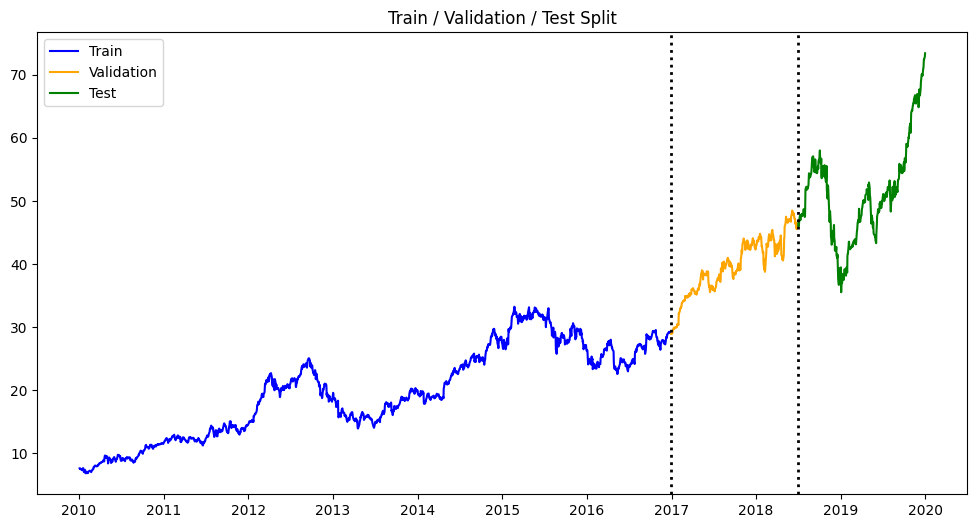


Using non-overlapping approach...

Scaling method: z-score
Train mean: 19.845500734297815, Train std: 7.079373036317053
Train scaled shape: (1761,), Val scaled: (377,), Test scaled: (378,)

Train Dataset length: 1701
Val Dataset length: 317
Test Dataset length: 318

Train Dataset shape: torch.Size([60, 1])
Val Dataset shape: torch.Size([60, 1])
Test Dataset shape: torch.Size([60, 1])

Train DataLoader batch count: 54
Val DataLoader batch count: 10
Test DataLoader batch count: 10

Train DataLoader batch shape: torch.Size([32, 60, 1])
Val DataLoader batch shape: torch.Size([32, 60, 1])
Test DataLoader batch shape: torch.Size([32, 60, 1])

Verification passed: Number of dates matches the number of dataset samples for each split.


In [ ]:
# Prepare the data
train_loader, val_loader, test_loader, scaling_params, split_dates = prepare_data_workflow(
    df,
    all_time_features,
    input_length=60,
    output_length=1,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    overlapping=False,
    scale=True,
    scaling_method='z-score',
    train_shuffle=False
)

# Get the scaling parameters
mean_, std_ = scaling_params['mean'], scaling_params['std']

In [ ]:
# Get the test set dates
test_dates = split_dates['test_dates']

# Print the length of the test set dates
print(f"Length of test set dates: {len(test_dates)}")

# Print the first ten test set dates
print("\nFirst ten test set dates:")
print(test_dates[:10])

# Print the last ten test set dates
print("\nLast ten test set dates:")
print(test_dates[-10:])

Length of test set dates: 318

First ten test set dates:
DatetimeIndex(['2018-09-26', '2018-09-27', '2018-09-28', '2018-10-01',
               '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05',
               '2018-10-08', '2018-10-09'],
              dtype='datetime64[ns]', name='Date', freq=None)

Last ten test set dates:
DatetimeIndex(['2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', freq=None)


# Model Definition

In [ ]:
class PositionalEmbedding(nn.Module):
    """
    Positional embeddings using sine and cosine patterns.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, L, ...]
        out = self.pe[:, :x.size(1)]
        return out

class TokenEmbedding(nn.Module):
    """
    Embeddings for the value tokens using a 1D convolution.
    """
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2

        self.tokenConv = nn.Conv1d(
            in_channels=c_in,
            out_channels=d_model,
            kernel_size=3,
            padding=padding,
            padding_mode='circular',
            bias=False
        )

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight,
                    mode='fan_in',
                    nonlinearity='leaky_relu'
                )

    def forward(self, x):
        # x: [B, L, C_in]
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x

class FixedEmbedding(nn.Module):
    """
    Fixed embeddings for encoding categorical attributes like month, day, weekday, etc.
    """
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()
        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        x = self.emb(x).detach()
        return x

class TemporalEmbedding(nn.Module):
    """
    Temporal embeddings for [month, day, weekday, day_of_year, quarter].
    """
    def __init__(self, d_model, embed_type='fixed'):
        super(TemporalEmbedding, self).__init__()
        # Define the sizes for the time-based features
        month_size = 13
        day_size = 32
        weekday_size = 7
        day_of_year_size = 367  # Accounting for leap years
        quarter_size = 5

        # Define the embedding type
        if embed_type == 'fixed':
            Embed = FixedEmbedding
        elif embed_type == 'learned':
            Embed = nn.Embedding
        else:
            raise ValueError(f"Unsupported embedding type: {embed_type}")

        # Define the embeddings for the time-based features
        self.month_embed = Embed(month_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_of_year_embed = Embed(day_of_year_size, d_model)
        self.quarter_embed = Embed(quarter_size, d_model)

    def forward(self, x):
        # x: [B, L, 5] = [month, day, weekday, day_of_year, quarter]
        x = x.long()

        # Apply the embeddings to the time-based features
        month_x = self.month_embed(x[:, :, 0])
        day_x = self.day_embed(x[:, :, 1])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_of_year_x = self.day_of_year_embed(x[:, :, 3])
        quarter_x = self.quarter_embed(x[:, :, 4])

        # Sum to get the returned output
        time_x = month_x + day_x + weekday_x + day_of_year_x + quarter_x
        return time_x

class DataEmbedding(nn.Module):
    """
    Combines value embeddings, positional embeddings, and temporal embeddings.
    """
    def __init__(self, c_in, d_model, embed_type='fixed', dropout=0.1):
        super(DataEmbedding, self).__init__()
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        # x: [B, L, 1], x_mark: [B, L, 5]
        x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        x = self.dropout(x)
        return x

In [ ]:
class MambaModel(nn.Module):
    """
    MambaModel using the Mamba module and DataEmbedding.
    """
    def __init__(self, d_model=128, d_state=16, d_conv=4, expand=2, output_dim=1, embed_type='fixed', dropout=0.1):
        """
        Parameters
        ----------
        d_model : int
            Dimension of the model.
        d_state : int
            Dimension of the state inside Mamba.
        d_conv : int
            Dimension of the convolution channel inside Mamba.
        expand : int
            Expansion factor for internal layers.
        output_dim : int
            Output dimension (e.g., 1 for univariate).
        embed_type : str
            Embedding type (e.g., 'fixed').
        dropout : float
            Dropout rate for the embedding process.
        """
        super(MambaModel, self).__init__()
        self.embedding = DataEmbedding(c_in=1, d_model=d_model, embed_type=embed_type, dropout=dropout)

        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

        self.out_layer = nn.Linear(d_model, output_dim, bias=False)

    def forward(self, x, x_mark):
        # x: [B, L, 1], x_mark: [B, L, 5]
        # Compute mean
        mean_enc = x.mean(dim=1, keepdim=True).detach()
        # Center
        x = x - mean_enc

        # Compute standard deviation
        std_enc = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-10).detach()
        # Scale
        x = x / std_enc

        # Apply embeddings
        x_emb = self.embedding(x, x_mark) # [B, L, d_model]

        # Pass embeddings through the Mamba model
        x_out = self.mamba(x_emb) # [B, L, d_model]

        # Project the model output to the target dimension
        x_out = self.out_layer(x_out) # [B, L, 1]

        # Perform inverse transformation
        x_out = x_out * std_enc + mean_enc

        return x_out

In [ ]:
class SMAPELoss(nn.Module):
    """
    Symmetric Mean Absolute Percentage Error (sMAPE) Loss.
    """
    def __init__(self, eps=1e-10):
        super(SMAPELoss, self).__init__()
        self.eps = eps

    def forward(self, pred, target):
        """
        Parameters
        ----------
        pred : torch.Tensor
            Predicted values of shape [B, L, 1].
        target : torch.Tensor
            True values of shape [B, L, 1].

        Returns
        -------
        smape : torch.Tensor
            sMAPE loss (scalar).
        """
        # Define the numerator and denominator
        numerator = torch.abs(pred - target)
        denominator = (torch.abs(pred) + torch.abs(target) + self.eps)

        # Compute sMAPE loss
        smape = 2.0 * numerator / denominator
        smape = torch.mean(smape) * 100

        return smape

In [ ]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MambaModel(
    d_model=16,
    d_state=8,
    d_conv=2,
    expand=2,
    output_dim=1,
    embed_type='fixed',
    dropout=0.1
).to(device)

# Initialize optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
smape_criterion = SMAPELoss()

# Print model configuration
print(f"Device: {device}")
print(f"Model: {model}")
print(f"Optimizer: {optimizer}")
print(f"Loss function: {smape_criterion}")

Device: cuda
Model: MambaModel(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 16)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 16)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 16)
      )
      (day_of_year_embed): FixedEmbedding(
        (emb): Embedding(367, 16)
      )
      (quarter_embed): FixedEmbedding(
        (emb): Embedding(5, 16)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (mamba): Mamba(
    (in_proj): Linear(in_features=16, out_features=64, bias=False)
    (conv1d): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,), groups=32)
    (act): SiLU()
    (x_proj): Linear(in_features=32, out_featur

# Model Training

In [ ]:
def train_one_epoch(model, optimizer, criterion, loader, device):
    """
    Train the model for one epoch.

    Parameters
    ----------
    model : nn.Module
        The PyTorch model.
    optimizer : torch.optim.Optimizer
        Optimizer for model parameters.
    criterion : nn.Module
        Loss function (e.g., sMAPE).
    loader : DataLoader
        Training DataLoader.
    device : torch.device
        Device to run the training on.

    Returns
    -------
    avg_loss : float
        Average loss metric.
    """
    model.train()
    total_loss = 0.0
    count = 0

    for x, y, x_mark, y_mark in loader:
        x, y, x_mark, y_mark = x.to(device), y.to(device), x_mark.to(device), y_mark.to(device)

        optimizer.zero_grad()
        out = model(x, x_mark)

        # Ensure prediction length matches target length
        output_length = y.size(1)
        if out.size(1) != output_length:
            out = out[:, -output_length:, :]

        loss = criterion(out, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        count += x.size(0)
        avg_loss = total_loss / count

    return avg_loss

In [ ]:
def evaluate(model, criterion, loader, device):
    """
    Evaluate the model on a given dataset (validation or test).

    Parameters
    ----------
    model : nn.Module
        The PyTorch model.
    criterion : nn.Module
        Loss function (e.g., sMAPE).
    loader : DataLoader
        DataLoader for validation or test set.
    device : torch.device
        Device to run the evaluation on.

    Returns
    -------
    avg_loss : float
        Average loss metric.
    """
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for x, y, x_mark, y_mark in loader:
            x, y, x_mark, y_mark = x.to(device), y.to(device), x_mark.to(device), y_mark.to(device)

            out = model(x, x_mark) # out: [B, L, 1]

            # Ensure prediction length matches target length
            output_length = y.size(1)
            if out.size(1) != output_length:
                out = out[:, -output_length:, :]

            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            count += x.size(0)
            avg_loss = total_loss / count

    return avg_loss

In [ ]:
def run_training(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=100,
    early_stopping_patience=5,
    lr_scheduler_patience=3,
    lr_scheduler_factor=0.1,
    print_progress=True,
    report_freq=1,
    checkpoint_path='best_model.pth'
):
    """
    Run the training loop with early stopping, checkpointing, and learning rate scheduling.

    Parameters
    ----------
    model : nn.Module
        PyTorch model.
    train_loader : DataLoader
        Training data loader.
    val_loader : DataLoader
        Validation data loader.
    criterion : nn.Module
        Loss function.
    optimizer : torch.optim.Optimizer
        Model optimizer.
    device : torch.device
        Compute device.
    epochs : int
        Maximum number of epochs.
    early_stopping_patience : int
        Early stopping patience.
    lr_scheduler_patience : int
        Learning rate scheduler patience.
    lr_scheduler_factor : float
        Learning rate scheduler factor.
    print_progress : bool
        Whether to print progress messages. Default is True.
    report_freq : int
        Frequency of progress reporting (in epochs). Defaults to every epoch.
    checkpoint_path : str
        Path to save the best model checkpoint.

    Returns
    -------
    model : nn.Module
        The trained model with the best validation performance.
    history : dict
        Training and validation loss history.
    best_epoch : int
        Epoch with the best validation performance.
    """
    best_val_loss = float('inf')
    best_epoch = None
    best_epoch_time = None
    best_epoch_lr = None
    patience_counter = 0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=lr_scheduler_factor,
        patience=lr_scheduler_patience,
        min_lr=1e-10
    )

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs + 1):  # Epoch counting starts from 1
        start_time = time.time()
        train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)
        val_loss = evaluate(model, criterion, val_loader, device)

        # Extract learning rate before and after scheduler step
        before_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        after_lr = optimizer.param_groups[0]['lr']

        # Check for learning rate adjustment
        if print_progress and (after_lr != before_lr):
            print(f"Learning rate adjusted after Epoch {epoch - 1}: {before_lr:.2e} -> {after_lr:.2e}")

        # Update best validation loss and save model if improved
        elapsed = time.time() - start_time
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_epoch_time = elapsed
            best_epoch_lr = after_lr
            torch.save(model.state_dict(), checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1

        # Record losses
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Progress reporting: Always print the first epoch and every report_freq-th epoch
        if print_progress and (epoch == 1 or epoch % report_freq == 0):
            print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Time: {elapsed:.2f}s | LR: {after_lr:.2e}")

        # Early stopping
        if patience_counter >= early_stopping_patience:
            if print_progress:
                print(f"Early Stopping triggered at Epoch {epoch}.")
            break

    # Load the best model
    model.load_state_dict(torch.load(checkpoint_path))

    # Final reporting
    if print_progress:
        print(f"\nFinal Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Time: {elapsed:.2f}s | LR: {after_lr:.2e}")
        print(f"Best Epoch {best_epoch}/{epochs} - Train Loss: {history['train_loss'][best_epoch-1]:.4f} | "
              f"Val Loss: {best_val_loss:.4f} | Time: {best_epoch_time:.2f}s | LR: {best_epoch_lr:.2e}")

    return model, history, best_epoch

In [ ]:
# Set the seed
set_seed()

# Train the model
model, history, best_epoch = run_training(
    model,
    train_loader,
    val_loader,
    smape_criterion,
    optimizer,
    device,
    epochs=100,
    early_stopping_patience=5,
    lr_scheduler_patience=3,
    lr_scheduler_factor=0.1,
    print_progress=True,
    report_freq=1,
    checkpoint_path='best_model.pth'
)

Epoch 1/100 - Train Loss: 26.2836 | Val Loss: 3.0346 | Time: 1.39s | LR: 1.00e-03
Epoch 2/100 - Train Loss: 19.8285 | Val Loss: 2.3385 | Time: 0.43s | LR: 1.00e-03
Epoch 3/100 - Train Loss: 17.1265 | Val Loss: 2.3677 | Time: 0.45s | LR: 1.00e-03
Epoch 4/100 - Train Loss: 16.5084 | Val Loss: 2.4580 | Time: 0.44s | LR: 1.00e-03
Epoch 5/100 - Train Loss: 15.5894 | Val Loss: 2.2122 | Time: 0.43s | LR: 1.00e-03
Epoch 6/100 - Train Loss: 14.5843 | Val Loss: 2.3658 | Time: 0.42s | LR: 1.00e-03
Epoch 7/100 - Train Loss: 15.3748 | Val Loss: 2.0978 | Time: 0.40s | LR: 1.00e-03
Epoch 8/100 - Train Loss: 13.6484 | Val Loss: 2.2935 | Time: 0.43s | LR: 1.00e-03
Epoch 9/100 - Train Loss: 14.5440 | Val Loss: 2.3408 | Time: 0.39s | LR: 1.00e-03
Epoch 10/100 - Train Loss: 14.2296 | Val Loss: 2.0959 | Time: 0.38s | LR: 1.00e-03
Epoch 11/100 - Train Loss: 14.4179 | Val Loss: 2.3797 | Time: 0.38s | LR: 1.00e-03
Epoch 12/100 - Train Loss: 13.4658 | Val Loss: 2.0160 | Time: 0.36s | LR: 1.00e-03
Epoch 13/100 

In [ ]:
def plot_training_history(history, x_tick_interval=10):
    """
    Plot the training and validation loss history with x-ticks at the first epoch
    and then every `x_tick_interval` epochs thereafter.

    Parameters
    ----------
    history : dict
        Dictionary containing 'train_loss' and 'val_loss' lists.
    x_tick_interval : int
        Interval for x-axis tick labels. Default is 10.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')

    # Generate x-tick positions: always include the first epoch, then every interval-th epoch
    if x_tick_interval > 0:
        # Start with the first epoch
        tick_positions = [1]
        # Add every x_tick_interval-th epoch starting from x_tick_interval
        tick_positions += list(range(x_tick_interval, len(epochs) + 1, x_tick_interval))

        # Ensure the last epoch is included if it is not already
        if tick_positions[-1] != len(epochs):
            tick_positions.append(len(epochs))
    else:
        # If interval is 0 or negative, default to showing all ticks
        tick_positions = epochs

    plt.xticks(tick_positions)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

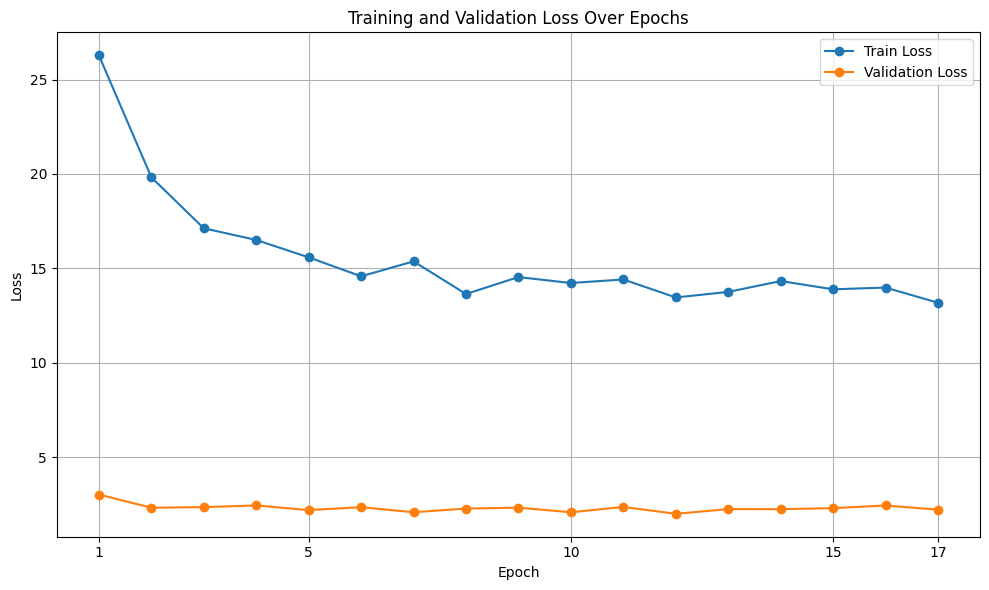

In [ ]:
# Plot the training and validation loss history
plot_training_history(history, x_tick_interval=5)

# Model Evaluation

In [ ]:
def evaluate_test_set(model, loader, device, scaling_params, epsilon=1e-10):
    """
    Evaluate the model on the test set and return inverse-transformed predictions and truths.

    Parameters
    ----------
    model : nn.Module
        Trained model.
    loader : DataLoader
        Test data loader.
    device : torch.device
        Compute device.
    scaling_params : dict
        Scaling parameters for inverse transformation.
    epsilon : float
        Small value to avoid division by zero.

    Returns
    -------
    test_preds_inv : np.ndarray
        Inverse-transformed predictions on the test set.
    test_trues_inv : np.ndarray
        Inverse-transformed true values on the test set.
    """
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for x, y, x_mark, y_mark in loader:
            x, y, x_mark, y_mark = x.to(device), y.to(device), x_mark.to(device), y_mark.to(device)

            out = model(x, x_mark)

            # Ensure prediction length matches target length
            output_length = y.size(1)
            if out.size(1) != output_length:
                out = out[:, -output_length:, :]
            out = out.cpu().numpy()
            y = y.cpu().numpy()

            preds.append(out)
            trues.append(y)

    preds = np.concatenate(preds, axis=0).squeeze()
    trues = np.concatenate(trues, axis=0).squeeze()

    if 'mean' in scaling_params and 'std' in scaling_params:
        print("Using mean and std for inverse transformation...")
        mean_ = scaling_params['mean']
        std_ = scaling_params['std']
        test_preds_inv = preds * (std_ + epsilon) + mean_
        test_trues_inv = trues * (std_ + epsilon) + mean_
    elif 'min' in scaling_params and 'max' in scaling_params:
        print("Using min and max for inverse transformation...")
        min_ = scaling_params['min']
        max_ = scaling_params['max']
        test_preds_inv = preds * (max_ - min_) + min_
        test_trues_inv = trues * (max_ - min_) + min_
    else:
        print("No scaling parameters found for inverse transformation. Using raw values...")
        test_preds_inv = preds
        test_trues_inv = trues

    return test_preds_inv, test_trues_inv

In [ ]:
# Get predictions
test_preds_inv, test_trues_inv = evaluate_test_set(model, test_loader, device, scaling_params)

print(f"\nLength of test_preds_inv: {len(test_preds_inv)}")
print(f"Length of test_trues_inv: {len(test_trues_inv)}")

Using mean and std for inverse transformation...

Length of test_preds_inv: 318
Length of test_trues_inv: 318


In [ ]:
def compute_metrics(pred, true, eps=1e-10):
    """
    Compute a set of evaluation metrics for time series predictions.

    Parameters
    ----------
    pred : np.ndarray
        Predicted values.
    true : np.ndarray
        Actual values.
    eps : float
        Small value to avoid division by zero.

    Returns
    -------
    metrics_df : pd.DataFrame
        DataFrame containing MSE, RMSE, MAE, MAPE, sMAPE, MASE.
    """
    mse = np.mean((true - pred) ** 2)
    rmse = np.sqrt(mse)

    mae = np.mean(np.abs(true - pred))

    mape = np.mean(np.abs((true - pred) / (true + eps))) * 100
    smape = 100 * np.mean(2.0 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + eps))

    if len(true) > 1:
        naive_pred = true[:-1]
        naive_true = true[1:]
        mase_denom = np.mean(np.abs(naive_true - naive_pred)) if len(naive_true) > 0 else 1.0
    else:
        mase_denom = 1.0
    mase = np.mean(np.abs(true - pred)) / (mase_denom + eps)

    metrics_df = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE'],
        'Value': [mse, rmse, mae, mape, smape, mase]
    }).set_index('Metric')

    return metrics_df

In [ ]:
# Create metrics DataFrame
metrics_df = compute_metrics(test_preds_inv, test_trues_inv)
print("Metrics on Test Set:")
display(metrics_df)

Metrics on Test Set:


,Value
Metric,
MSE,1.150479
RMSE,1.072604
MAE,0.838005
MAPE (%),1.687690
sMAPE (%),1.689708
MASE,1.251358


In [ ]:
# def plot_test_predictions(test_preds_inv, test_trues_inv):
#     """
#     Plot actual vs. predicted values on the test set.

#     Parameters
#     ----------
#     test_preds_inv : np.ndarray
#         Inverse-transformed predictions.
#     test_trues_inv : np.ndarray
#         Inverse-transformed true values.
#     """
#     plt.figure(figsize=(12, 6))
#     plt.plot(test_trues_inv, label='Actual', color='blue')
#     plt.plot(test_preds_inv, label='Predicted', color='red', linestyle='--')
#     plt.title('Test Set: Actual vs. Predicted')
#     plt.xlabel('Time Steps')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.show()

In [ ]:
# # Plot actual vs. predicted values
# plot_test_predictions(test_preds_inv, test_trues_inv)

In [ ]:
# def plot_test_predictions(test_preds_inv, test_trues_inv, test_dates, xtick_interval=30):
#     """
#     Plot actual vs. predicted values on the test set with date-based x-ticks.

#     Parameters
#     ----------
#     test_preds_inv : np.ndarray
#         Inverse-transformed predictions.
#     test_trues_inv : np.ndarray
#         Inverse-transformed true values.
#     test_dates : pd.DatetimeIndex
#         Dates corresponding to the test set values.
#     xtick_interval : int
#         Interval between x-ticks, by default 30.
#     """
#     plt.figure(figsize=(12, 6))
#     plt.plot(test_dates, test_trues_inv, label='Actual', color='blue')
#     plt.plot(test_dates, test_preds_inv, label='Predicted', color='red', linestyle='--')

#     plt.title('Test Set: Actual vs. Predicted')
#     plt.xlabel('Date')
#     plt.ylabel('Value')
#     plt.legend()

#     # Set x-ticks with specified interval
#     plt.xticks(test_dates[::xtick_interval], rotation=45)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# # Plot actual vs. predicted values
# xtick_interval = 30
# plot_test_predictions(
#     test_preds_inv,
#     test_trues_inv,
#     test_dates,
#     xtick_interval=xtick_interval
# )

In [ ]:
class QuarterFormatter(mdates.DateFormatter):
    def __call__(self, x, pos=0):
        dt = mdates.num2date(x)
        quarter = (dt.month - 1) // 3 + 1
        output = f"{dt.year}-Q{quarter}"
        return output

In [ ]:
def plot_test_predictions(test_preds_inv, test_trues_inv, test_dates, tick_interval='M', locator_interval=None):
    """
    Plot actual vs. predicted values on the test set with actual dates on the x-axis.

    Parameters
    ----------
    test_preds_inv : np.ndarray
        Inverse-transformed predictions.
    test_trues_inv : np.ndarray
        Inverse-transformed true values.
    test_dates : pd.DatetimeIndex or list of pd.Timestamp
        Dates corresponding to the test set.
    tick_interval : str
        Interval for x-ticks. Options include:
            'D' - Daily
            'W' - Weekly
            'M' - Monthly
            'Q' - Quarterly
            'Y' - Yearly
        Default is 'M' for monthly.
    locator_interval : int
        Interval for mdates locator. If not provided, defaults based on `tick_interval`.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, test_trues_inv, label='Actual', color='blue')
    plt.plot(test_dates, test_preds_inv, label='Predicted', color='red', linestyle='--')

    plt.title('Test Set: Actual vs. Predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

    # Set default locator_interval based on tick_interval if not provided
    if locator_interval is None:
        if tick_interval == 'D':
            locator_interval = 15    # Every 15 days
        elif tick_interval == 'W':
            locator_interval = 2     # Every 2 weeks
        elif tick_interval == 'M':
            locator_interval = 1     # Every month
        elif tick_interval == 'Q':
            locator_interval = 3     # Every quarter
        elif tick_interval == 'Y':
            locator_interval = 1     # Every year
        else:
            locator_interval = None  # Let AutoDateLocator handle it

    # Define the locator and formatter based on the tick_interval
    if tick_interval == 'D':
        locator = mdates.DayLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        formatter = mdates.DateFormatter('%Y-%m-%d')
    elif tick_interval == 'W':
        locator = mdates.WeekdayLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        formatter = mdates.DateFormatter('%Y-%m-%d')
    elif tick_interval == 'M':
        locator = mdates.MonthLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        formatter = mdates.DateFormatter('%Y-%m')
    elif tick_interval == 'Q':
        locator = mdates.MonthLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        formatter = QuarterFormatter()
    elif tick_interval == 'Y':
        locator = mdates.YearLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        formatter = mdates.DateFormatter('%Y')
    else:
        locator = mdates.AutoDateLocator()
        formatter = mdates.DateFormatter('%Y-%m-%d')

    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

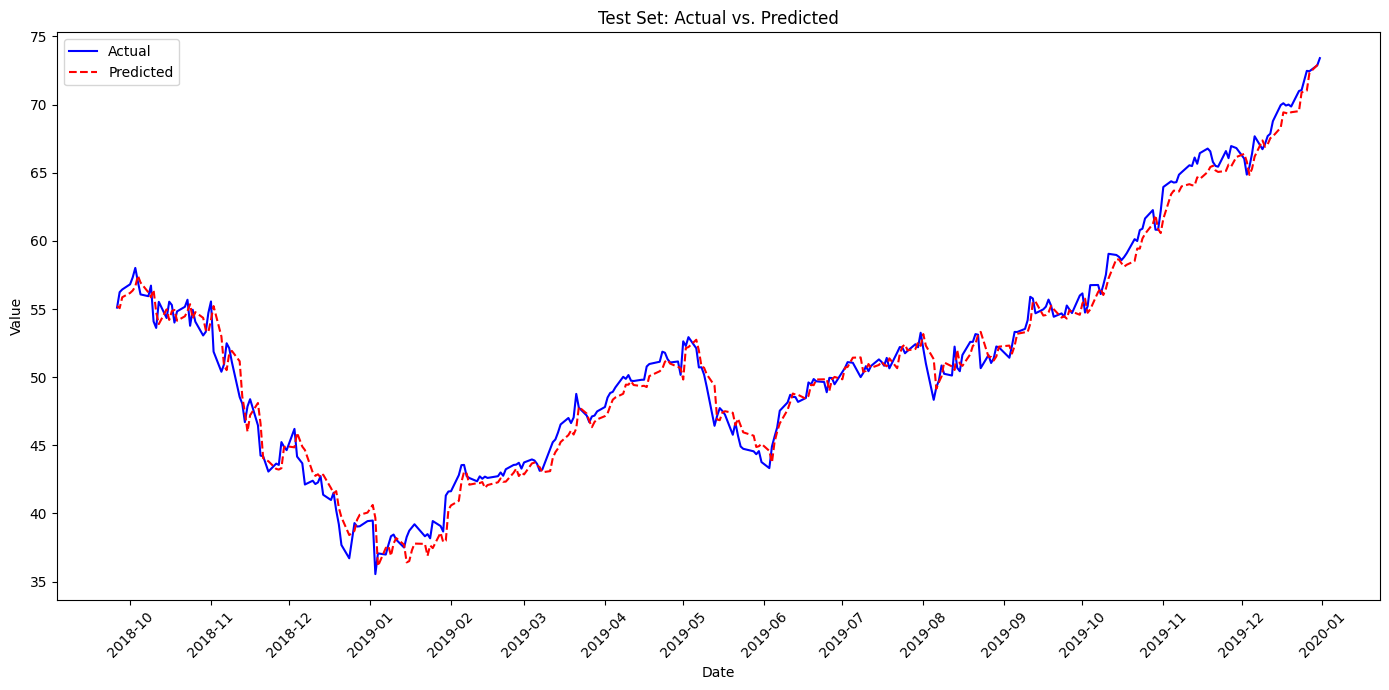

In [ ]:
# Plot actual vs. predicted values
tick_interval = 'M'
plot_test_predictions(
    test_preds_inv,
    test_trues_inv,
    test_dates,
    tick_interval=tick_interval
)

In [ ]:
# Get trained model weights
weights = model.state_dict()

# Save the weights to a file
torch.save(weights, 'model_weights.pth')

In [ ]:
# Save the test_loader, device, scaling_params, and test_dates
torch.save((test_loader, device, scaling_params, test_dates), 'test_loader_device_scaling_params_test_dates.pth')

In [ ]:
# Load the saved weights
loaded_weights = torch.load('model_weights.pth')

# Load the weights into the model
model.load_state_dict(loaded_weights)

<All keys matched successfully>

In [ ]:
# Load the test_loader, device, scaling_params, and test_dates
test_loader, device, scaling_params, test_dates = torch.load('test_loader_device_scaling_params_test_dates.pth')

Using mean and std for inverse transformation...


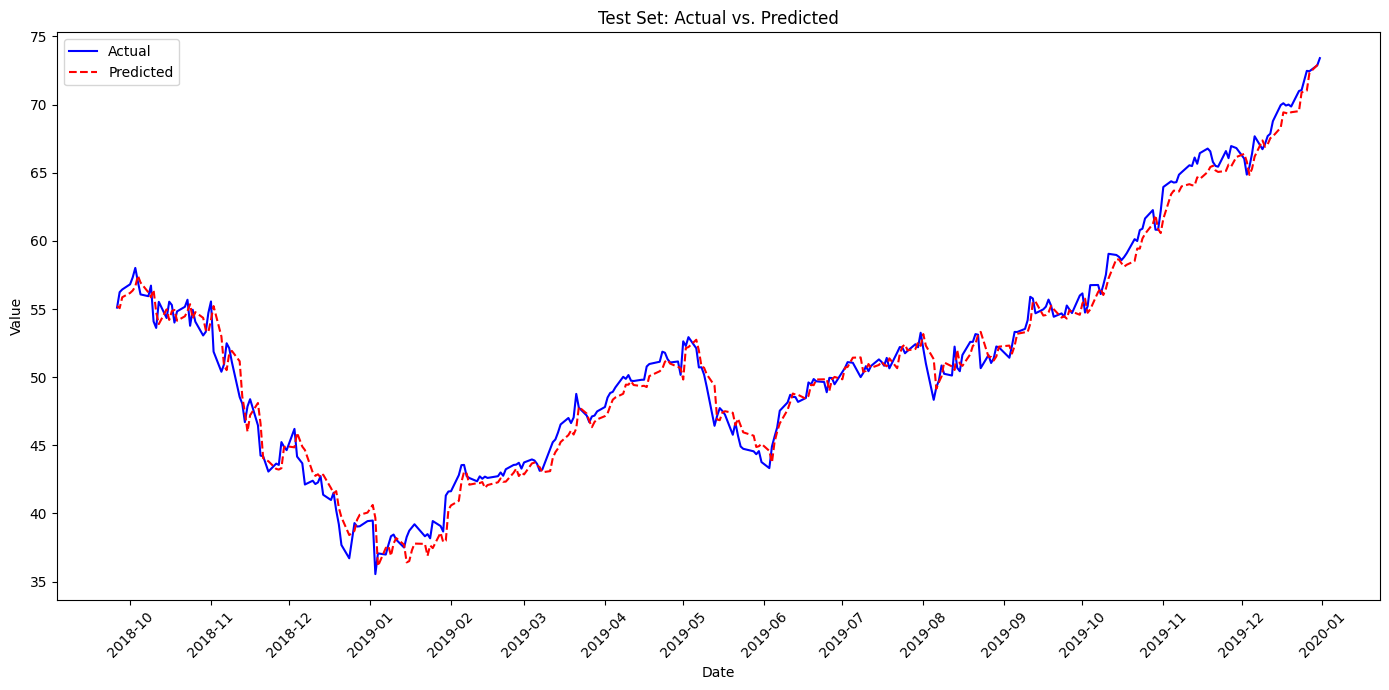

In [ ]:
# Get predictions
test_preds_inv, test_trues_inv = evaluate_test_set(model, test_loader, device, scaling_params)

# Plot actual vs. predicted values
plot_test_predictions(
    test_preds_inv,
    test_trues_inv,
    test_dates,
    tick_interval=tick_interval
)

# Model Tuning

In [ ]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter tuning with constraints.

    Parameters
    ----------
    trial : optuna.trial.Trial
        A single trial object that allows sampling hyperparameters.

    Returns
    -------
    min_val_loss : float
        Minimum validation loss for the current trial.
    loss_gap : float
        Difference between the maximum and minimum validation loss.
    """
    # Define allowed (d_model, d_conv) pairs
    model_conv_pairs = []
    d_model_choices = [4, 8, 16, 32, 64, 128, 256, 512]
    d_conv_choices = [2, 4, 8, 16, 32, 64, 128, 256]

    for d_model in d_model_choices:
        valid_d_conv = [conv for conv in d_conv_choices if conv <= d_model]
        for d_conv in valid_d_conv:
            model_conv_pairs.append((d_model, d_conv))

    # Suggest (d_model, d_conv) pair
    d_model_conv = trial.suggest_categorical("d_model_conv", model_conv_pairs)
    d_model, d_conv = d_model_conv

    # Define and suggest expand from allowed choices
    allowed_expand_choices = [2, 4]
    expand = trial.suggest_categorical("expand", allowed_expand_choices)

    # Suggest other hyperparameters
    d_state = trial.suggest_categorical("d_state", [4, 8, 16, 32, 64, 128, 256])
    embed_type = trial.suggest_categorical("embed_type", ['fixed', 'learned'])
    dropout = trial.suggest_float("dropout", 0.05, 0.7)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    early_stopping_patience = trial.suggest_int("early_stopping_patience", 4, 20)
    max_lr_scheduler_patience = int(early_stopping_patience - 1)
    lr_scheduler_patience = trial.suggest_int("lr_scheduler_patience", 2, max_lr_scheduler_patience)
    lr_scheduler_factor = trial.suggest_float("lr_scheduler_factor", 0.05, 0.7)

    # Initialize model
    model = MambaModel(
        d_model=d_model,
        d_state=d_state,
        d_conv=d_conv,
        expand=expand,
        output_dim=1,
        embed_type=embed_type,
        dropout=dropout
    ).to(device)

    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = SMAPELoss()

    # Set checkpoint path for the trial
    checkpoint_path = f"trial_{trial.number}_best_model.pth"

    # Run training
    try:
        model, history, best_epoch = run_training(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            epochs=100,
            early_stopping_patience=early_stopping_patience,
            lr_scheduler_patience=lr_scheduler_patience,
            lr_scheduler_factor=lr_scheduler_factor,
            print_progress=False,
            report_freq=1,
            checkpoint_path=checkpoint_path
        )

        # Get val_loss measures
        val_losses = history['val_loss']
        min_val_loss = min(val_losses)
        max_val_loss = max(val_losses)
        loss_gap = max_val_loss - min_val_loss

        # Save additional metadata
        trial.set_user_attr("best_epoch", best_epoch)

        return min_val_loss, loss_gap

    # If an error occurs, return 'inf'
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        trial.set_user_attr("best_epoch", 0)
        return float("inf"), float("inf")

In [ ]:
# Set the seed
set_seed()

# Optuna study configuration
study = optuna.create_study(
    directions=["minimize", "minimize"],
    study_name="Mamba_MultiObjective_Optimization"
)

# Run the study
study.optimize(objective, n_trials=50, timeout=7200)

[I 2024-12-18 15:03:51,699] A new study created in memory with name: Mamba_MultiObjective_Optimization
[I 2024-12-18 15:04:01,134] Trial 0 finished with values: [2.2473716423714576, 0.9007723470591595] and parameters: {'d_model_conv': (16, 2), 'expand': 2, 'd_state': 256, 'embed_type': 'learned', 'dropout': 0.5544478244781716, 'lr': 0.011230948775800376, 'weight_decay': 3.489183630432745e-05, 'early_stopping_patience': 16, 'lr_scheduler_patience': 4, 'lr_scheduler_factor': 0.6378383672980841}.
[I 2024-12-18 15:04:30,371] Trial 1 finished with values: [199.99985829061515, 0.00014170938484880935] and parameters: {'d_model_conv': (512, 128), 'expand': 4, 'd_state': 4, 'embed_type': 'learned', 'dropout': 0.2917250727192169, 'lr': 0.00391148289315157, 'weight_decay': 1.6837738819231097e-05, 'early_stopping_patience': 10, 'lr_scheduler_patience': 6, 'lr_scheduler_factor': 0.49782363847048955}.
[I 2024-12-18 15:04:42,581] Trial 2 finished with values: [2.4991277745845566, 0.7193170511384115] 

In [ ]:
def display_plotly_with_static(fig, static_format='png'):
    """
    Displays both an interactive Plotly figure and a static image version.

    Parameters:
    - fig: A Plotly figure object.
    - static_format: The format for the static image ('png', 'svg', etc.).
    """
    # Display interactive plot
    fig.show()
    print("\n")

    # Generate and display static image
    try:
        # Generate static image as bytes
        img_bytes = pio.to_image(fig, format=static_format)

        # Display the static image
        if static_format == 'svg':
            display(SVG(img_bytes))
        else:
            display(Image(img_bytes))
    except Exception as e:
        print(f"\nAn error occurred while generating the static image: {e}")

Number of trials on the Pareto front: 20



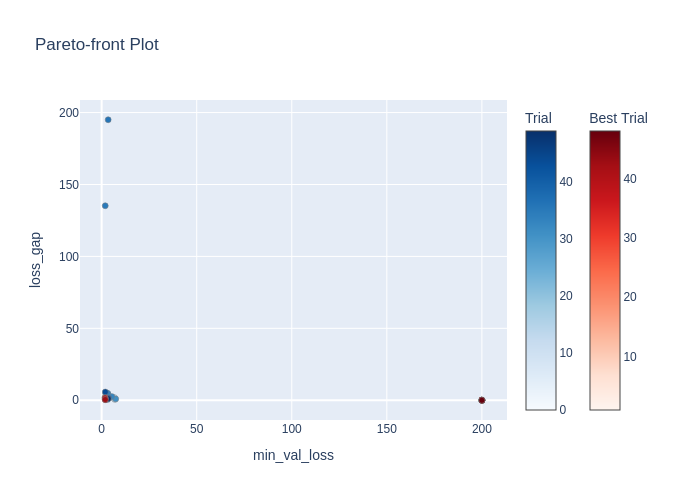

In [ ]:
# Print the number of trials on the Pareto front
print(f"Number of trials on the Pareto front: {len(study.best_trials)}\n")

# Visualize the Pareto front
pareto_fig = optuna.visualization.plot_pareto_front(
    study,
    target_names=["min_val_loss", "loss_gap"]
)

display_plotly_with_static(pareto_fig)

Covariance Matrix:


array([[8609.24685547, -506.59266598],
       [-506.59266598, 1090.00055607]])

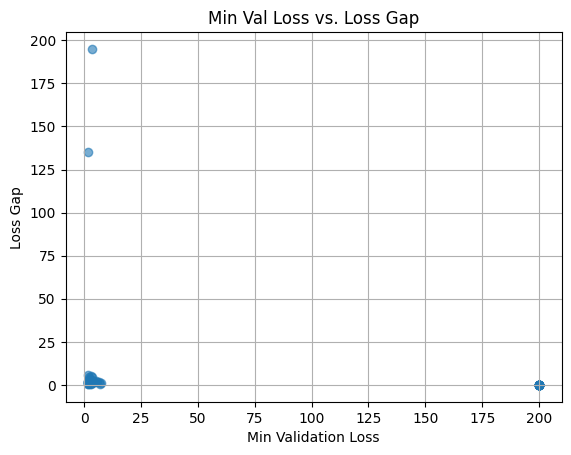

In [ ]:
# Extract completed trials
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Extract objective values
min_val_losses = [t.values[0] for t in completed_trials]
loss_gaps = [t.values[1] for t in completed_trials]

# Calculate covariance matrix
covariance_matrix = np.cov(min_val_losses, loss_gaps)
print("Covariance Matrix:")
display(covariance_matrix)
print("\n")

# Visualize
plt.scatter(min_val_losses, loss_gaps, alpha=0.6)
plt.xlabel('Min Validation Loss')
plt.ylabel('Loss Gap')
plt.title('Min Val Loss vs. Loss Gap')
plt.grid(True)
plt.show()

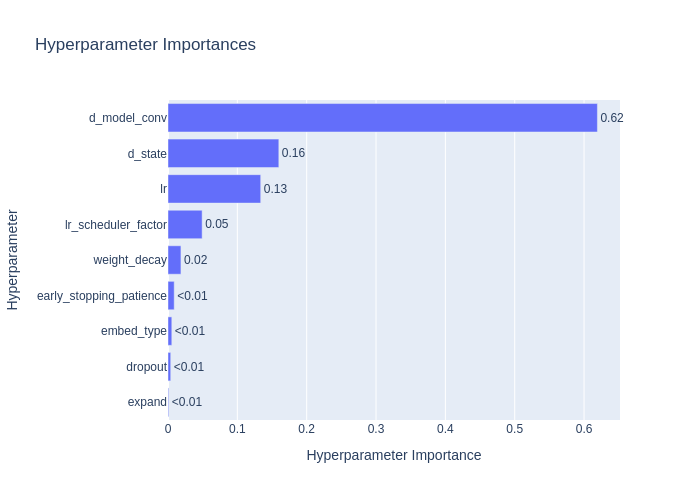

In [ ]:
# Plot parameter importances for min_val_loss
param_imp_val_loss = optuna.visualization.plot_param_importances(
    study,
    target=lambda t: t.values[0],
    target_name="min_val_loss"
)

display_plotly_with_static(param_imp_val_loss)

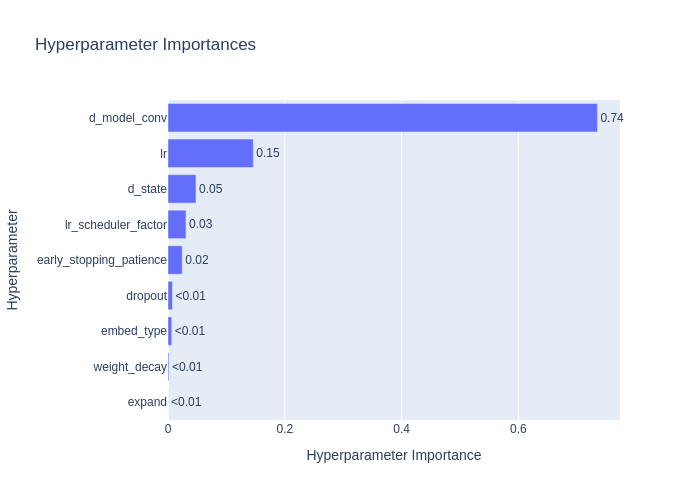

In [ ]:
# Plot parameter importances for loss_gap
param_imp_loss_gap = optuna.visualization.plot_param_importances(
    study,
    target=lambda t: t.values[1],
    target_name="loss_gap"
)

display_plotly_with_static(param_imp_loss_gap)

In [ ]:
# Select the trial with the lowest validation loss
trial_with_lowest_val_loss = min(study.best_trials, key=lambda t: t.values[0])
print("Trial with lowest min_val_loss:")
print(f"\tnumber: {trial_with_lowest_val_loss.number}")
print(f"\tparams: {trial_with_lowest_val_loss.params}")
print(f"\tvalues: {trial_with_lowest_val_loss.values}")

Trial with lowest min_val_loss:
	number: 39
	params: {'d_model_conv': (128, 32), 'expand': 2, 'd_state': 8, 'embed_type': 'fixed', 'dropout': 0.43541687668179635, 'lr': 0.0021791932226419533, 'weight_decay': 4.779334012518177e-05, 'early_stopping_patience': 17, 'lr_scheduler_patience': 10, 'lr_scheduler_factor': 0.45633138748444013}
	values: [1.8145031184428122, 1.5929777569575263]


In [ ]:
# Select the trial with the lowest loss gap
trial_with_lowest_loss_gap = min(study.best_trials, key=lambda t: t.values[1])
print("Trial with lowest loss_gap:")
print(f"\tnumber: {trial_with_lowest_loss_gap.number}")
print(f"\tparams: {trial_with_lowest_loss_gap.params}")
print(f"\tvalues: {trial_with_lowest_loss_gap.values}")

Trial with lowest loss_gap:
	number: 4
	params: {'d_model_conv': (512, 8), 'expand': 4, 'd_state': 256, 'embed_type': 'learned', 'dropout': 0.07449659962227825, 'lr': 0.03251791079511026, 'weight_decay': 0.0011676319178290078, 'early_stopping_patience': 14, 'lr_scheduler_patience': 8, 'lr_scheduler_factor': 0.4085170589423081}
	values: [200.0, 0.0]


In [ ]:
# Minimum epochs threshold
MIN_EPOCHS = 3

# Filter trials based on user attributes
filtered_trials = [
    t for t in study.best_trials
    if t.user_attrs.get("best_epoch", 0) >= MIN_EPOCHS
]

if filtered_trials:
    # Select the best trial based on min_val_loss and loss_gap
    best_trial = min(filtered_trials, key=lambda t: (t.values[0], t.values[1]))
    print("Best Generalized Trial:")
    print(f"\tNumber: {best_trial.number}")
    print(f"\tParams: {best_trial.params}")
    print(f"\tValues: Min Loss={best_trial.values[0]}, Loss Gap={best_trial.values[1]}")
    print(f"\tEpochs: {best_trial.user_attrs['best_epoch']}")
else:
    print("No stable trials found meeting the epoch threshold. Consider lowering the MIN_EPOCHS or reviewing the Pareto front.")

Best Generalized Trial:
	Number: 39
	Params: {'d_model_conv': (128, 32), 'expand': 2, 'd_state': 8, 'embed_type': 'fixed', 'dropout': 0.43541687668179635, 'lr': 0.0021791932226419533, 'weight_decay': 4.779334012518177e-05, 'early_stopping_patience': 17, 'lr_scheduler_patience': 10, 'lr_scheduler_factor': 0.45633138748444013}
	Values: Min Loss=1.8145031184428122, Loss Gap=1.5929777569575263
	Epochs: 34


In [ ]:
# Retrieve the best hyperparameters from the best trial
best_params = best_trial.params.copy()

# Unpack the composite parameter 'd_model_conv'
d_model_conv = best_params.pop("d_model_conv")  # Remove 'd_model_conv' from the params
best_d_model, best_d_conv = d_model_conv        # Unpack into 'd_model' and 'd_conv'

In [ ]:
# Extract other hyperparameters
best_expand = best_params["expand"]
best_d_state = best_params["d_state"]
best_embed_type = best_params["embed_type"]
best_dropout = best_params["dropout"]
best_lr = best_params["lr"]
best_weight_decay = best_params["weight_decay"]
best_early_stopping_patience = best_params["early_stopping_patience"]
best_lr_scheduler_patience = best_params["lr_scheduler_patience"]
best_lr_scheduler_factor = best_params["lr_scheduler_factor"]

In [ ]:
# Initialize the model with the best hyperparameters
final_model = MambaModel(
    d_model=best_d_model,
    d_state=best_d_state,
    d_conv=best_d_conv,
    expand=best_expand,
    embed_type=best_embed_type,
    dropout=best_dropout,
    output_dim=1
).to(device)

In [ ]:
# Set the seed
set_seed()

# Initialize optimizer and loss function
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
criterion = SMAPELoss()

# Define the checkpoint path for saving the final model
checkpoint_path = "best_model_final.pth"
print("Starting training with the best hyperparameters...\n")

# Train the final model
final_model, final_history, final_best_epoch = run_training(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=100,
    early_stopping_patience=best_early_stopping_patience,
    lr_scheduler_patience=best_lr_scheduler_patience,
    lr_scheduler_factor=best_lr_scheduler_factor,
    print_progress=True,
    report_freq=1,
    checkpoint_path=checkpoint_path
)

Starting training with the best hyperparameters...

Epoch 1/100 - Train Loss: 26.9801 | Val Loss: 2.4182 | Time: 0.43s | LR: 2.18e-03
Epoch 2/100 - Train Loss: 22.7968 | Val Loss: 2.4001 | Time: 0.40s | LR: 2.18e-03
Epoch 3/100 - Train Loss: 21.1509 | Val Loss: 2.5707 | Time: 0.37s | LR: 2.18e-03
Epoch 4/100 - Train Loss: 20.5261 | Val Loss: 2.7512 | Time: 0.36s | LR: 2.18e-03
Epoch 5/100 - Train Loss: 16.0135 | Val Loss: 2.0662 | Time: 0.36s | LR: 2.18e-03
Epoch 6/100 - Train Loss: 22.1116 | Val Loss: 2.9218 | Time: 0.36s | LR: 2.18e-03
Epoch 7/100 - Train Loss: 16.2288 | Val Loss: 2.4933 | Time: 0.36s | LR: 2.18e-03
Epoch 8/100 - Train Loss: 18.1668 | Val Loss: 1.8987 | Time: 0.35s | LR: 2.18e-03
Epoch 9/100 - Train Loss: 17.9598 | Val Loss: 1.9731 | Time: 0.36s | LR: 2.18e-03
Epoch 10/100 - Train Loss: 15.5049 | Val Loss: 2.4517 | Time: 0.35s | LR: 2.18e-03
Epoch 11/100 - Train Loss: 21.6810 | Val Loss: 1.9544 | Time: 0.36s | LR: 2.18e-03
Epoch 12/100 - Train Loss: 16.8377 | Val Los

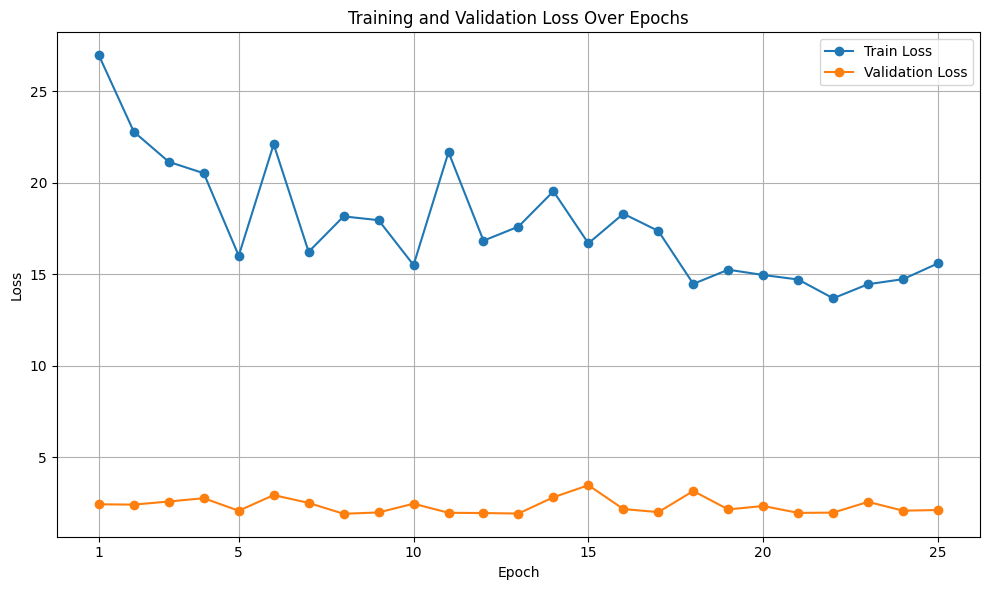

In [ ]:
# Plot the training and validation loss history
plot_training_history(final_history, x_tick_interval=5)

# Model Re-Evaluation

In [ ]:
# Get predictions
final_test_preds_inv, test_trues_inv = evaluate_test_set(final_model, test_loader, device, scaling_params)

print(f"\nLength of final_test_preds_inv: {len(final_test_preds_inv)}")
print(f"Length of test_trues_inv: {len(test_trues_inv)}")

Using mean and std for inverse transformation...

Length of final_test_preds_inv: 318
Length of test_trues_inv: 318


In [ ]:
# Create metrics DataFrame
final_metrics_df = compute_metrics(final_test_preds_inv, test_trues_inv)
print("Metrics on Test Set:")
display(final_metrics_df)

Metrics on Test Set:


,Value
Metric,
MSE,1.069051
RMSE,1.033949
MAE,0.780516
MAPE (%),1.577240
sMAPE (%),1.579826
MASE,1.165511


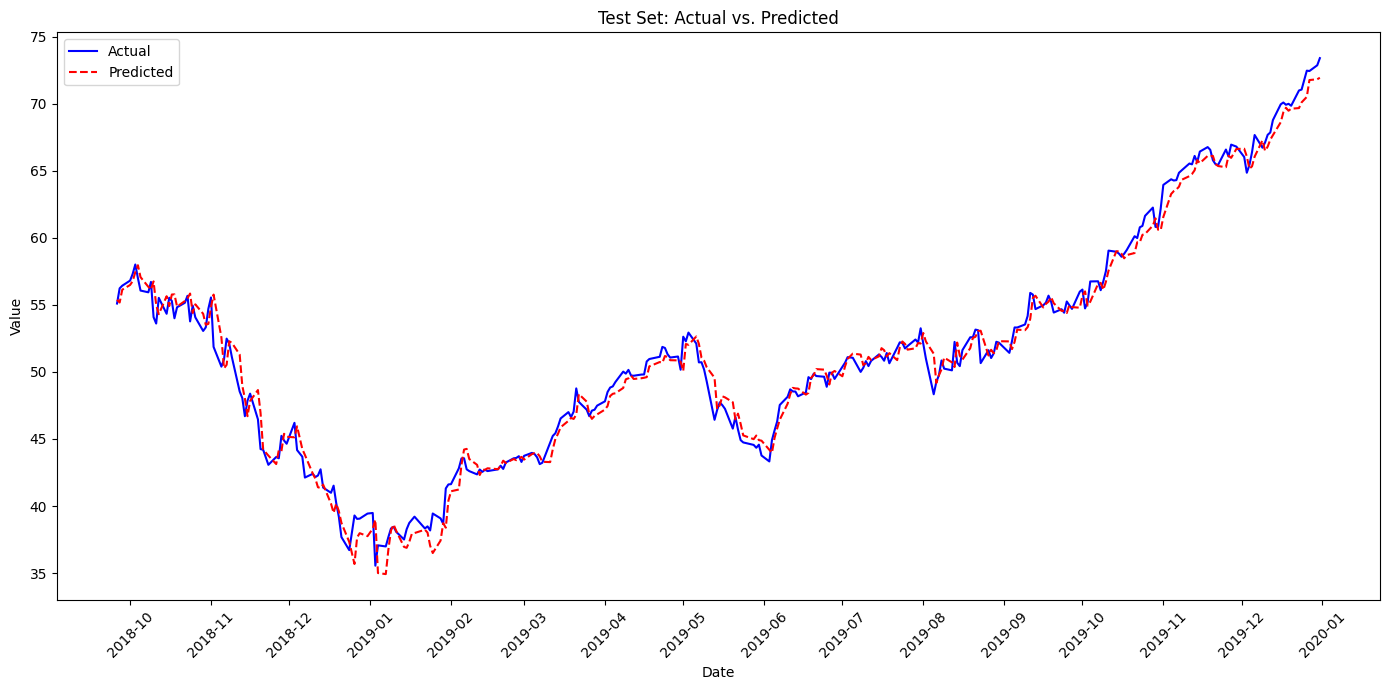

In [ ]:
# Plot actual vs. predicted values
plot_test_predictions(
    final_test_preds_inv,
    test_trues_inv,
    test_dates,
    tick_interval=tick_interval
)

# Results Comparison

In [ ]:
# Add a column to each DataFrame to indicate the model
metrics_df['Model'] = 'Untuned'
final_metrics_df['Model'] = 'Tuned'

# Combine the two DataFrames
metrics_combined = pd.concat([metrics_df, final_metrics_df], axis=0).reset_index()

# Pivot the table to display the comparison
metrics_pivot = metrics_combined.pivot(index='Metric', columns='Model', values='Value')
print("Metrics Comparison:")
display(metrics_pivot)

Metrics Comparison:


Model,Tuned,Untuned
Metric,,
MAE,0.780516,0.838005
MAPE (%),1.577240,1.687690
MASE,1.165511,1.251358
MSE,1.069051,1.150479
RMSE,1.033949,1.072604
sMAPE (%),1.579826,1.689708


In [ ]:
# Create both DataFrames
metrics_df = compute_metrics(test_preds_inv, test_trues_inv)
final_metrics_df = compute_metrics(final_test_preds_inv, test_trues_inv)

# Reset the index to turn 'Metric' back into a column
metrics_df = metrics_df.reset_index()
final_metrics_df = final_metrics_df.reset_index()

# Add a column to each DataFrame to indicate the model
metrics_df['Model'] = 'Untuned'
final_metrics_df['Model'] = 'Tuned'

# Combine the two DataFrames
metrics_combined = pd.concat([metrics_df, final_metrics_df], axis=0).reset_index(drop=True)

# Verify the combined DataFrame
print("Combined DataFrame:")
display(metrics_combined)

# Proceed with pivoting
metrics_pivot = metrics_combined.pivot(index='Metric', columns='Model', values='Value')

# Re-order the columns to have 'Untuned' first and 'Tuned' second
metrics_pivot = metrics_pivot[['Untuned', 'Tuned']]

# Round the values for better readability
metrics_pivot = metrics_pivot.round(3)

# Rename the index and columns for clarity
metrics_pivot.index.name = 'Metric'
metrics_pivot.columns.name = 'Model'

# Define the desired order of metrics
desired_order = ['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE']

# Re-order the rows based on the desired order
metrics_pivot = metrics_pivot.loc[desired_order]

# Display the formatted comparison
print("\nMetrics Comparison:")
display(
    metrics_pivot.style
    .set_properties(**{'text-align': 'center'})
    .background_gradient(cmap='Blues', axis=None)
    .format("{:.3f}")
)

Combined DataFrame:


,Metric,Value,Model
0,MSE,1.150479,Untuned
1,RMSE,1.072604,Untuned
2,MAE,0.838005,Untuned
3,MAPE (%),1.687690,Untuned
4,sMAPE (%),1.689708,Untuned
5,MASE,1.251358,Untuned
6,MSE,1.069051,Tuned
7,RMSE,1.033949,Tuned
8,MAE,0.780516,Tuned
9,MAPE (%),1.577240,Tuned



Metrics Comparison:


Model,Untuned,Tuned
Metric,,
MSE,1.150,1.069
RMSE,1.073,1.034
MAE,0.838,0.781
MAPE (%),1.688,1.577
sMAPE (%),1.690,1.580
MASE,1.251,1.166


In [ ]:
def plot_side_by_side(
    actual,
    preds_model1,
    preds_model2,
    test_dates,
    model1_name='Model 1',
    model2_name='Model 2',
    title1=None,
    title2=None,
    tick_interval='M',
    locator_interval=None
):
    """
    Plot actual vs. predicted values for two models side by side with actual dates.

    Parameters
    ----------
    actual : np.ndarray
        True values of the test set.
    preds_model1 : np.ndarray
        Predictions from the first model.
    preds_model2 : np.ndarray
        Predictions from the second model.
    test_dates : pd.DatetimeIndex or list of pd.Timestamp
        Dates corresponding to the test set values.
    model1_name : str
        Name of the first model (default is 'Model 1').
    model2_name : str
        Name of the second model (default is 'Model 2').
    title1 : str
        Title for the first subplot. If None, defaults to 'Actual vs. {model1_name} Prediction Values'.
    title2 : str
        Title for the second subplot. If None, defaults to 'Actual vs. {model2_name} Prediction Values'.
    tick_interval : str
        Interval for x-ticks. Options include:
            'D' - Daily
            'W' - Weekly
            'M' - Monthly
            'Q' - Quarterly
            'Y' - Yearly
        Default is 'M' for monthly.
    locator_interval : int
        Interval for mdates locator. If not provided, defaults based on `tick_interval`.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    # Set default locator_interval based on tick_interval if not provided
    if locator_interval is None:
        if tick_interval == 'D':
            locator_interval = 15    # Every 15 days
        elif tick_interval == 'W':
            locator_interval = 2     # Every 2 weeks
        elif tick_interval == 'M':
            locator_interval = 1     # Every month
        elif tick_interval == 'Q':
            locator_interval = 3     # Every quarter
        elif tick_interval == 'Y':
            locator_interval = 1     # Every year
        else:
            locator_interval = None  # Let AutoDateLocator handle it

    # Define a helper function to set locators and formatters
    def set_date_locator(ax, tick_interval, locator_interval):
        if tick_interval == 'D':
            locator = mdates.DayLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
            formatter = mdates.DateFormatter('%Y-%m-%d')
        elif tick_interval == 'W':
            locator = mdates.WeekdayLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
            formatter = mdates.DateFormatter('%Y-%m-%d')
        elif tick_interval == 'M':
            locator = mdates.MonthLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
            formatter = mdates.DateFormatter('%Y-%m')
        elif tick_interval == 'Q':
            locator = mdates.MonthLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
            formatter = QuarterFormatter()
        elif tick_interval == 'Y':
            locator = mdates.YearLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
            formatter = mdates.DateFormatter('%Y')
        else:
            locator = mdates.AutoDateLocator()
            formatter = mdates.DateFormatter('%Y-%m-%d')

        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=45)

    # Subplot for the first model
    ax = axes[0]
    ax.plot(test_dates, actual, label='Actual', color='blue')
    ax.plot(test_dates, preds_model1, label=f'{model1_name} Predictions', color='red', linestyle='--')
    if title1:
        ax.set_title(title1)
    else:
        ax.set_title(f'Actual vs. {model1_name} Prediction Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    set_date_locator(ax, tick_interval, locator_interval)
    ax.legend()

    # Subplot for the second model
    ax = axes[1]
    ax.plot(test_dates, actual, label='Actual', color='blue')
    ax.plot(test_dates, preds_model2, label=f'{model2_name} Predictions', color='#E65100', linestyle='--')
    if title2:
        ax.set_title(title2)
    else:
        ax.set_title(f'Actual vs. {model2_name} Prediction Values')
    ax.set_xlabel('Date')
    set_date_locator(ax, tick_interval, locator_interval)
    ax.legend()

    plt.tight_layout()
    plt.show()

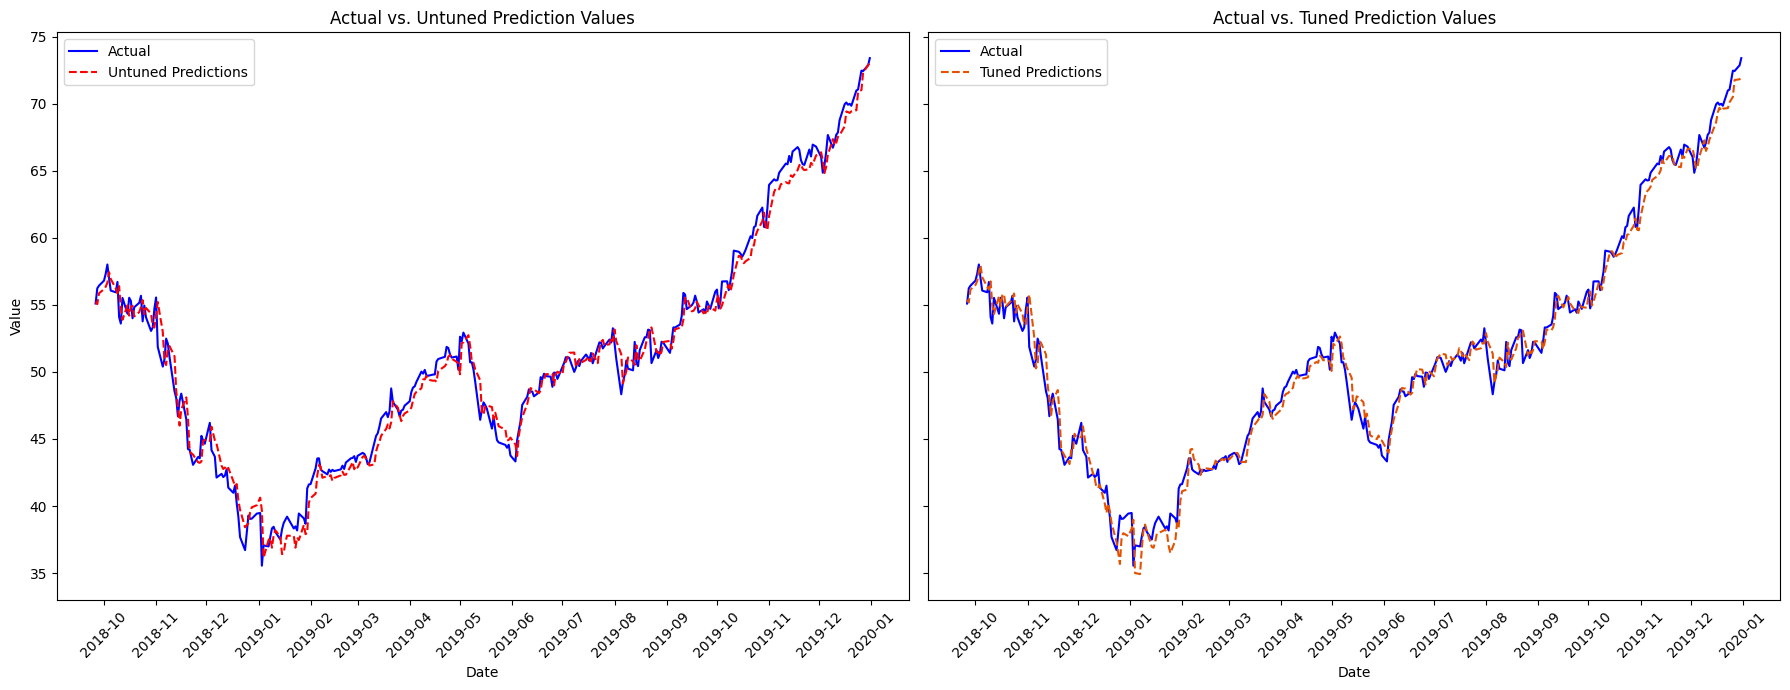

In [ ]:
# Plot comparison of actual vs. predicted values
plot_side_by_side(
    actual=test_trues_inv,
    preds_model1=test_preds_inv,
    preds_model2=final_test_preds_inv,
    test_dates=test_dates,
    model1_name='Untuned',
    model2_name='Tuned',
    title1='Actual vs. Untuned Prediction Values',
    title2='Actual vs. Tuned Prediction Values',
    tick_interval=tick_interval
)

# More Tuning

In [ ]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter tuning with constraints.

    Parameters
    ----------
    trial : optuna.trial.Trial
        A single trial object that allows sampling hyperparameters.

    Returns
    -------
    composite_metric : float
        The composite metric value for the current trial.
    """
    # Define allowed (d_model, d_conv) pairs
    model_conv_pairs = []
    d_model_choices = [4, 8, 16, 32, 64, 128, 256, 512]
    d_conv_choices = [2, 4, 8, 16, 32, 64, 128, 256]

    for d_model in d_model_choices:
        valid_d_conv = [conv for conv in d_conv_choices if conv <= d_model]
        for d_conv in valid_d_conv:
            model_conv_pairs.append((d_model, d_conv))

    # Suggest (d_model, d_conv) pair
    d_model_conv = trial.suggest_categorical("d_model_conv", model_conv_pairs)
    d_model, d_conv = d_model_conv

    # Define and suggest expand from allowed choices
    allowed_expand_choices = [2, 4]
    expand = trial.suggest_categorical("expand", allowed_expand_choices)

    # Suggest other hyperparameters
    d_state = trial.suggest_categorical("d_state", [4, 8, 16, 32, 64, 128, 256])
    embed_type = trial.suggest_categorical("embed_type", ['fixed', 'learned'])
    dropout = trial.suggest_float("dropout", 0.05, 0.7)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    early_stopping_patience = trial.suggest_int("early_stopping_patience", 4, 20)
    max_lr_scheduler_patience = int(early_stopping_patience - 1)
    lr_scheduler_patience = trial.suggest_int("lr_scheduler_patience", 2, max_lr_scheduler_patience)
    lr_scheduler_factor = trial.suggest_float("lr_scheduler_factor", 0.05, 0.7)

    # Suggest weights for the composite metric
    w_min_val_loss = trial.suggest_float("w_min_val_loss", 0.1, 0.9)
    w_loss_gap = 1.0 - w_min_val_loss

    # Define ideal points
    z_min_val_loss = 0.0
    z_loss_gap = 0.0

    # Define expected normalization ranges
    MIN_VAL_LOSS_EXPECTED = 0.0      # Lower bound for min_val_loss
    MAX_VAL_LOSS_EXPECTED = 200.0    # Upper bound for min_val_loss
    MIN_LOSS_GAP_EXPECTED = 0.0      # Lower bound for loss_gap
    MAX_LOSS_GAP_EXPECTED = 25.0     # Upper bound for loss_gap

    # Initialize model
    model = MambaModel(
        d_model=d_model,
        d_state=d_state,
        d_conv=d_conv,
        expand=expand,
        output_dim=1,
        embed_type=embed_type,
        dropout=dropout
    ).to(device)

    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = SMAPELoss()

    # Set checkpoint path for the trial
    checkpoint_path = f"trial_{trial.number}_best_model_2.pth"

    # Run training
    try:
        model, history, best_epoch = run_training(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            epochs=100,
            early_stopping_patience=early_stopping_patience,
            lr_scheduler_patience=lr_scheduler_patience,
            lr_scheduler_factor=lr_scheduler_factor,
            print_progress=False,
            report_freq=1,
            checkpoint_path=checkpoint_path
        )

        # Get val_loss measures
        val_losses = history['val_loss']
        min_val_loss = min(val_losses)
        max_val_loss = max(val_losses)
        loss_gap = max_val_loss - min_val_loss

        def normalize(value, min_expected, max_expected):
            return (value - min_expected) / (max_expected - min_expected)

        # Normalize the objectives
        min_val_loss_normalized = normalize(min_val_loss, MIN_VAL_LOSS_EXPECTED, MAX_VAL_LOSS_EXPECTED)
        loss_gap_normalized = normalize(loss_gap, MIN_LOSS_GAP_EXPECTED, MAX_LOSS_GAP_EXPECTED)

        # Clamp the normalized values between 0 and 1
        min_val_loss_normalized = max(0.0, min(min_val_loss_normalized, 1.0))
        loss_gap_normalized = max(0.0, min(loss_gap_normalized, 1.0))

        # Calculate weighted distances from ideal points
        # Since z_min_val_loss and z_loss_gap are 0, and we are minimizing,
        # the distances are the normalized values themselves
        distance_min_val_loss = w_min_val_loss * min_val_loss_normalized
        distance_loss_gap = w_loss_gap * loss_gap_normalized

        # Composite metric is the maximum of the weighted distances
        composite_metric = max(distance_min_val_loss, distance_loss_gap)

        # Save additional metadata
        trial.set_user_attr("best_epoch", best_epoch)

        return composite_metric

    # If an error occurs, return 'inf'
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        trial.set_user_attr("best_epoch", 0)
        return float("inf")

In [ ]:
# Set the seed
set_seed()

# Optuna study configuration
study = optuna.create_study(
    direction="minimize",
    study_name="Mamba_Tchebycheff_Optimization"
)

# Run the study
study.optimize(objective, n_trials=50, timeout=7200)

[I 2024-12-18 15:33:48,247] A new study created in memory with name: Mamba_Tchebycheff_Optimization
[I 2024-12-18 15:33:58,916] Trial 0 finished with value: 0.08784030741226098 and parameters: {'d_model_conv': (16, 2), 'expand': 4, 'd_state': 16, 'embed_type': 'learned', 'dropout': 0.5495176426126922, 'lr': 0.00012051450852096509, 'weight_decay': 5.7323194992371025e-05, 'early_stopping_patience': 5, 'lr_scheduler_patience': 4, 'lr_scheduler_factor': 0.18414599292009848, 'w_min_val_loss': 0.2928257409151044}. Best is trial 0 with value: 0.08784030741226098.
[I 2024-12-18 15:34:30,860] Trial 1 finished with value: 0.01770725856070278 and parameters: {'d_model_conv': (128, 16), 'expand': 4, 'd_state': 256, 'embed_type': 'learned', 'dropout': 0.5858032565367577, 'lr': 6.012299121616268e-05, 'weight_decay': 0.011662761054432704, 'early_stopping_patience': 5, 'lr_scheduler_patience': 4, 'lr_scheduler_factor': 0.12253571195555499, 'w_min_val_loss': 0.5290894504694696}. Best is trial 1 with va

In [ ]:
# Display the best trial
best_trial = study.best_trial
print("Best trial:")
print(f"  Value (Composite Metric): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (Composite Metric): 0.00796523700486587
  Params: 
    d_model_conv: (32, 2)
    expand: 2
    d_state: 64
    embed_type: fixed
    dropout: 0.20446142022276148
    lr: 0.005934919385898504
    weight_decay: 3.06300865917412e-05
    early_stopping_patience: 17
    lr_scheduler_patience: 13
    lr_scheduler_factor: 0.472149418788683
    w_min_val_loss: 0.8299535923177717


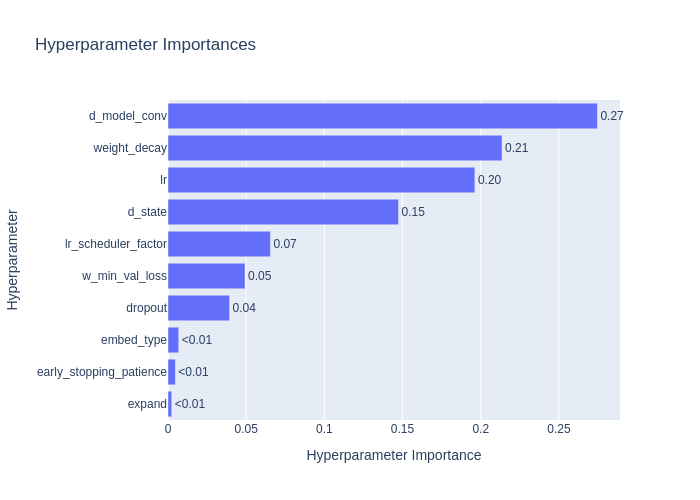

In [ ]:
# Plot parameter importances for composite_metric
param_imp_composite = optuna.visualization.plot_param_importances(
    study,
    target=lambda t: t.values[0],
    target_name="composite_metric"
)

display_plotly_with_static(param_imp_composite)

In [ ]:
# Retrieve the best hyperparameters from the best trial
best_params = best_trial.params.copy()

# Unpack the composite parameter 'd_model_conv'
d_model_conv = best_params.pop("d_model_conv")  # Remove 'd_model_conv' from the params
best_d_model, best_d_conv = d_model_conv        # Unpack into 'd_model' and 'd_conv'

In [ ]:
# Extract other hyperparameters
best_expand = best_params["expand"]
best_d_state = best_params["d_state"]
best_embed_type = best_params["embed_type"]
best_dropout = best_params["dropout"]
best_lr = best_params["lr"]
best_weight_decay = best_params["weight_decay"]
best_early_stopping_patience = best_params["early_stopping_patience"]
best_lr_scheduler_patience = best_params["lr_scheduler_patience"]
best_lr_scheduler_factor = best_params["lr_scheduler_factor"]
best_w_min_val_loss = best_params["w_min_val_loss"]
best_w_loss_gap = 1.0 - best_w_min_val_loss

In [ ]:
# Initialize the model with the best hyperparameters
final_model_2 = MambaModel(
    d_model=best_d_model,
    d_state=best_d_state,
    d_conv=best_d_conv,
    expand=best_expand,
    embed_type=best_embed_type,
    dropout=best_dropout,
    output_dim=1
).to(device)

In [ ]:
# Set the seed
set_seed()

# Initialize optimizer and loss function
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
criterion = SMAPELoss()

# Define the checkpoint path for saving the final model
checkpoint_path = "best_model_final_2.pth"
print("Starting training with the best hyperparameters...\n")

# Train the final model
final_model_2, final_history_2, final_best_epoch_2 = run_training(
    model=final_model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=100,
    early_stopping_patience=best_early_stopping_patience,
    lr_scheduler_patience=best_lr_scheduler_patience,
    lr_scheduler_factor=best_lr_scheduler_factor,
    print_progress=True,
    report_freq=1,
    checkpoint_path=checkpoint_path
)

Starting training with the best hyperparameters...

Epoch 1/100 - Train Loss: 33.7119 | Val Loss: 6.1453 | Time: 0.38s | LR: 5.93e-03
Epoch 2/100 - Train Loss: 32.6026 | Val Loss: 6.1453 | Time: 0.36s | LR: 5.93e-03
Epoch 3/100 - Train Loss: 33.1991 | Val Loss: 6.1453 | Time: 0.35s | LR: 5.93e-03
Epoch 4/100 - Train Loss: 33.4539 | Val Loss: 6.1453 | Time: 0.35s | LR: 5.93e-03
Epoch 5/100 - Train Loss: 32.9270 | Val Loss: 6.1453 | Time: 0.35s | LR: 5.93e-03
Epoch 6/100 - Train Loss: 32.6337 | Val Loss: 6.1453 | Time: 0.35s | LR: 5.93e-03
Epoch 7/100 - Train Loss: 32.3525 | Val Loss: 6.1453 | Time: 0.35s | LR: 5.93e-03
Epoch 8/100 - Train Loss: 32.8581 | Val Loss: 6.1453 | Time: 0.35s | LR: 5.93e-03
Epoch 9/100 - Train Loss: 33.5773 | Val Loss: 6.1453 | Time: 0.36s | LR: 5.93e-03
Epoch 10/100 - Train Loss: 33.6096 | Val Loss: 6.1453 | Time: 0.35s | LR: 5.93e-03
Epoch 11/100 - Train Loss: 32.6758 | Val Loss: 6.1453 | Time: 0.36s | LR: 5.93e-03
Epoch 12/100 - Train Loss: 33.2481 | Val Los

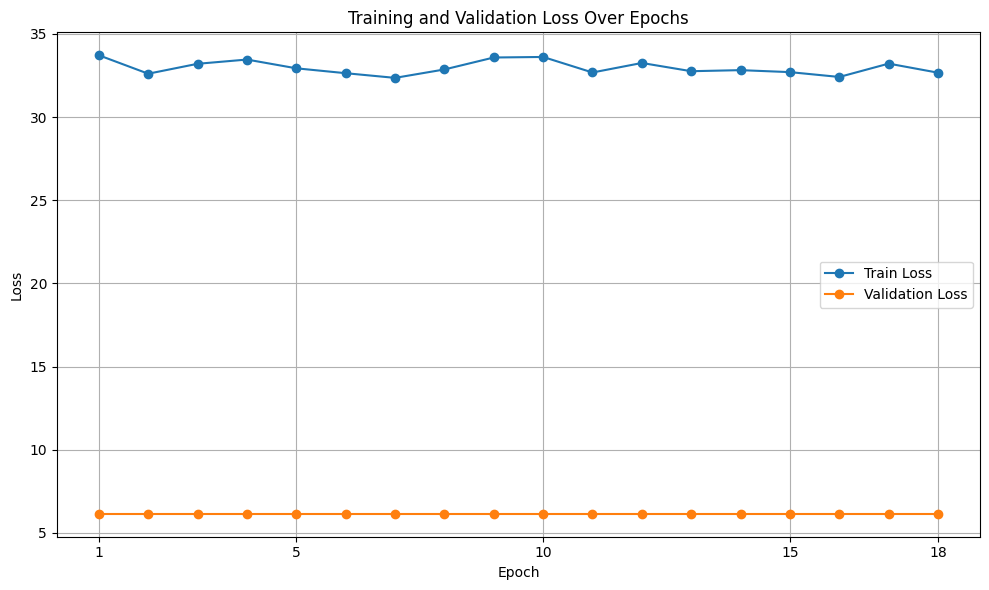

In [ ]:
# Plot the training and validation loss history
plot_training_history(final_history_2, x_tick_interval=5)

# Model Re-Evaluation

In [ ]:
# Get predictions
final_test_preds_inv_2, test_trues_inv = evaluate_test_set(final_model_2, test_loader, device, scaling_params)

print(f"\nLength of final_test_preds_inv_2: {len(final_test_preds_inv_2)}")
print(f"Length of test_trues_inv: {len(test_trues_inv)}")

Using mean and std for inverse transformation...

Length of final_test_preds_inv_2: 318
Length of test_trues_inv: 318


In [ ]:
# Create metrics DataFrame
final_metrics_df_2 = compute_metrics(final_test_preds_inv_2, test_trues_inv)
print("Metrics on Test Set:")
display(final_metrics_df_2)

Metrics on Test Set:


,Value
Metric,
MSE,18.139336
RMSE,4.259030
MAE,3.420878
MAPE (%),7.092351
sMAPE (%),6.877118
MASE,5.108254


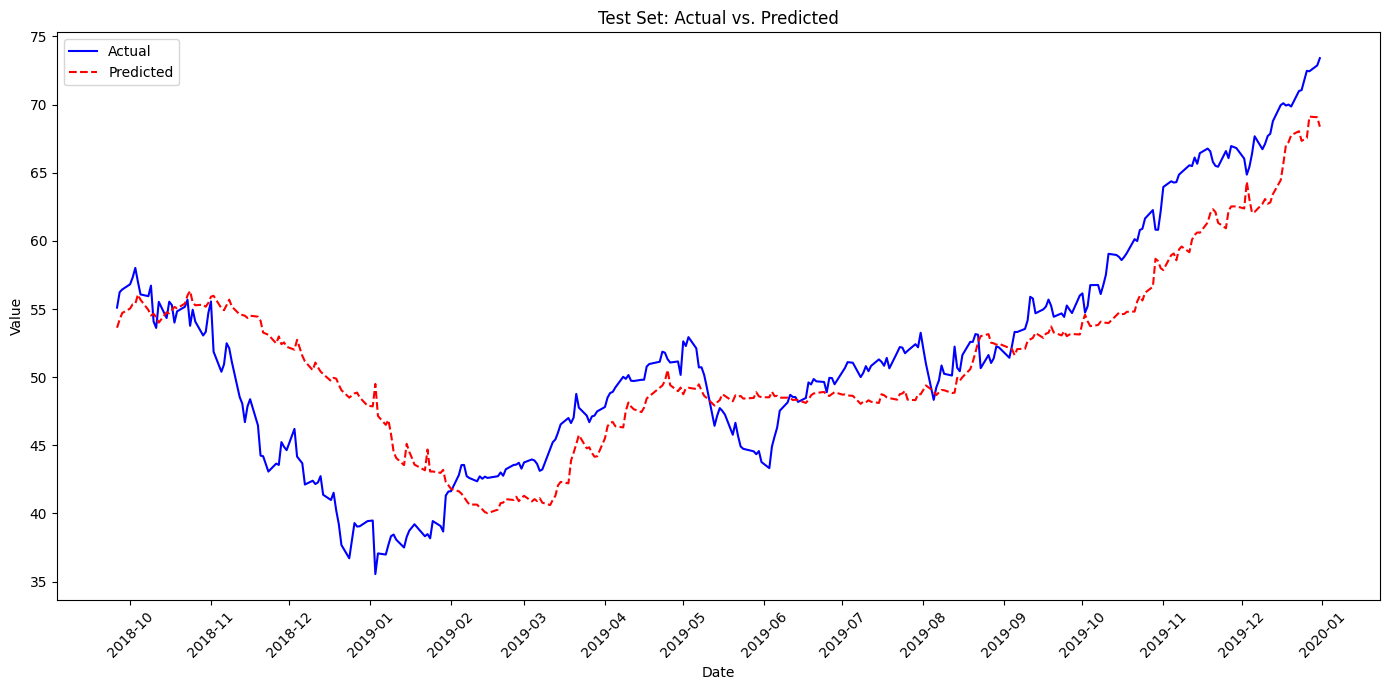

In [ ]:
# Plot actual vs. predicted values
plot_test_predictions(
    final_test_preds_inv_2,
    test_trues_inv,
    test_dates,
    tick_interval=tick_interval
)

# Tuning Comparison

In [ ]:
def compare_models_metrics(preds1, preds2, actual, model1_name, model2_name, desired_order=None):
    """
    Compare metrics between two models.

    Parameters
    ----------
    preds1 : array-like
        Predictions from the first model.
    preds2 : array-like
        Predictions from the second model.
    actual : array-like
        Actual target values.
    model1_name : str
        Name of the first model (gets priority in column order).
    model2_name : str
        Name of the second model.
    desired_order : list of str
        Desired order of metrics. If None, defaults to ['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE'].

    Returns
    -------
    metrics_pivot : pd.DataFrame
        A pivoted DataFrame comparing the two models' metrics.
    """

    if desired_order is None:
        desired_order = ['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE']

    # Compute metrics for both models
    metrics_df1 = compute_metrics(preds1, actual).reset_index()
    metrics_df2 = compute_metrics(preds2, actual).reset_index()

    # Add Model column
    metrics_df1['Model'] = model1_name
    metrics_df2['Model'] = model2_name

    # Combine the DataFrames
    metrics_combined = pd.concat([metrics_df1, metrics_df2], axis=0).reset_index(drop=True)

    # Pivot the combined DataFrame
    metrics_pivot = metrics_combined.pivot(index='Metric', columns='Model', values='Value')

    # Re-order the columns based on model priority (model1 first)
    metrics_pivot = metrics_pivot[[model1_name, model2_name]]

    # Round the values for better readability
    metrics_pivot = metrics_pivot.round(3)

    # Rename the index and columns for clarity
    metrics_pivot.index.name = 'Metric'
    metrics_pivot.columns.name = 'Model'

    # Re-order the rows based on the desired order
    try:
        metrics_pivot = metrics_pivot.loc[desired_order]
    except KeyError as e:
        missing = list(set(desired_order) - set(metrics_pivot.index))
        print(f"Warning: The following metrics are missing and will be skipped: {missing}")
        metrics_pivot = metrics_pivot.loc[metrics_pivot.index.intersection(desired_order)]

    # Display the combined DataFrame
    print("Combined DataFrame:")
    display(metrics_combined)

    # Display the formatted comparison with styling
    print("\nMetrics Comparison:")
    styled_pivot = (
        metrics_pivot.style
        .set_properties(**{'text-align': 'center'})
        .background_gradient(cmap='Blues', axis=None)
        .format("{:.3f}")
    )
    display(styled_pivot)

    return metrics_pivot

In [ ]:
# Compare the tuned model metrics
metrics_pivot = compare_models_metrics(
    preds1=final_test_preds_inv,
    preds2=final_test_preds_inv_2,
    actual=test_trues_inv,
    model1_name='Method 1',
    model2_name='Method 2',
    desired_order=['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE']
)

Combined DataFrame:


,Metric,Value,Model
0,MSE,1.069051,Method 1
1,RMSE,1.033949,Method 1
2,MAE,0.780516,Method 1
3,MAPE (%),1.577240,Method 1
4,sMAPE (%),1.579826,Method 1
5,MASE,1.165511,Method 1
6,MSE,18.139336,Method 2
7,RMSE,4.259030,Method 2
8,MAE,3.420878,Method 2
9,MAPE (%),7.092351,Method 2



Metrics Comparison:


Model,Method 1,Method 2
Metric,,
MSE,1.069,18.139
RMSE,1.034,4.259
MAE,0.781,3.421
MAPE (%),1.577,7.092
sMAPE (%),1.580,6.877
MASE,1.166,5.108


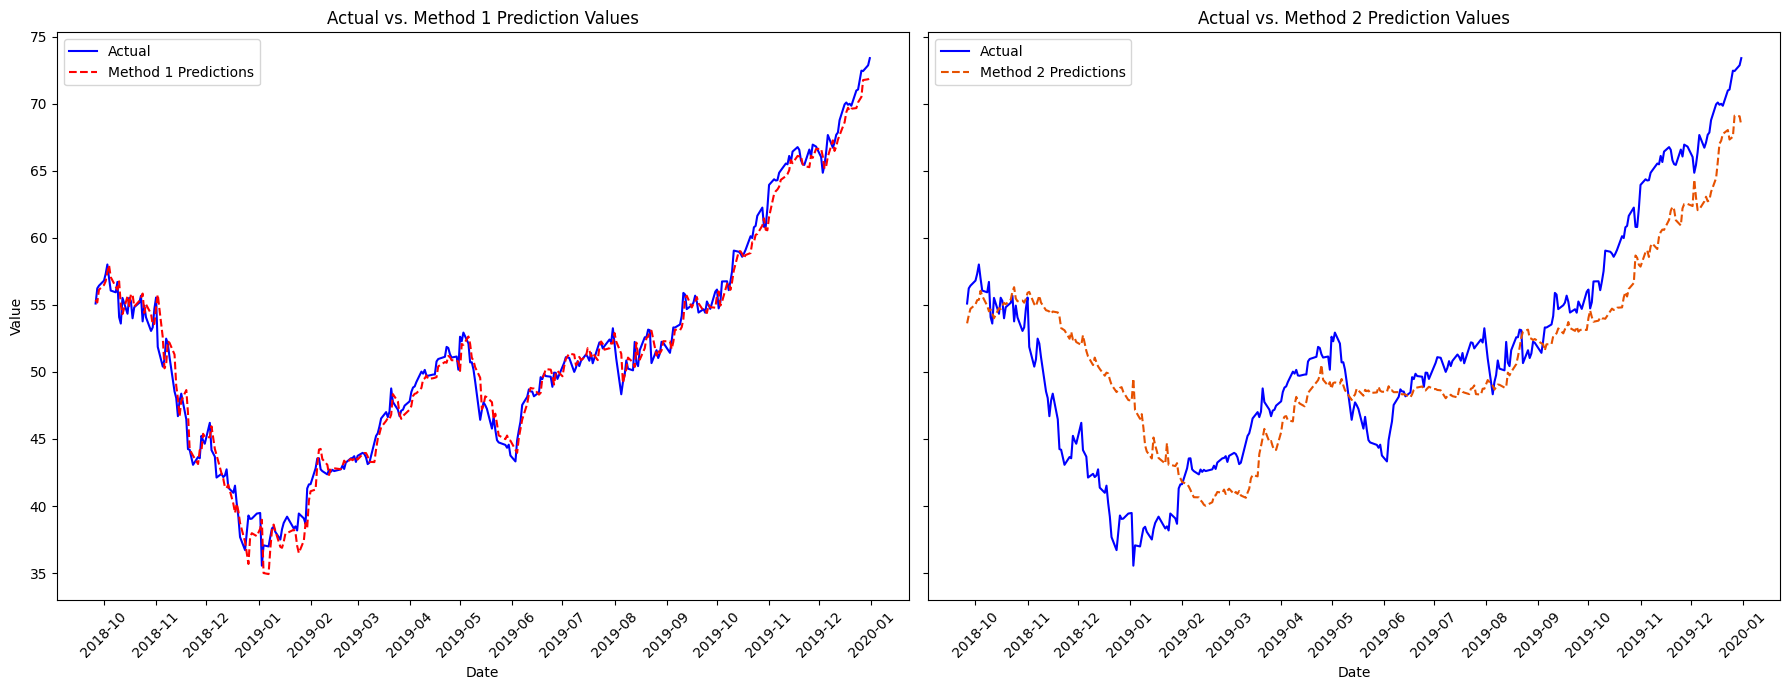

In [ ]:
# Plot comparison of actual vs. predicted values
plot_side_by_side(
    actual=test_trues_inv,
    preds_model1=final_test_preds_inv,
    preds_model2=final_test_preds_inv_2,
    test_dates=test_dates,
    model1_name='Method 1',
    model2_name='Method 2',
    title1='Actual vs. Method 1 Prediction Values',
    title2='Actual vs. Method 2 Prediction Values',
    tick_interval=tick_interval
)